### 구글드라이브 연결 및 주최측에서 제공한 데이터 압축파일 해제

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!cp -r "/content/drive/MyDrive/Colab Notebooks/2022 상추의 생육 환경 생성"/open.zip .
!unzip -n -q open.zip -d data

### 학습된 데이터 파일
AutoML에서 생성된 모델의 학습 데이터파일을 다운로드해서 압축을 해제해야 함 -> 압축이 해제되면 AutoML_5 폴더가 생성되고 그 밑에 AutoML로 학습된 파일들이 풀림

In [4]:
!pip install --upgrade gdown
!gdown --id 1xOmeLq9x2zjQpdWkNoQJ4_SSM4sIkQPe
!unzip -n -q AutoML-2022-12-19-0900.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0
/usr/local/lib/python3.8/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1xOmeLq9x2zjQpdWkNoQJ4_SSM4sIkQPe
To: /content/AutoML-2022-12-19-0900.zip
100% 79.5M/79.5M [00:00<00:00, 105MB/s]


### 라이브러리 설치
mljar-supervised(AutoML)와 폰트 파일을 설치하고 런타임을 다시 시작해야 함

In [5]:
!pip install mljar-supervised
!pip install optuna

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 112 kB 4.4 MB/s 
     |████████████████████████████████| 193.6 MB 49 kB/s 
     |████████████████████████████████| 2.0 MB 30.8 MB/s 
     |████████████████████████████████| 76.6 MB 23 kB/s 
     |████████████████████████████████| 72 kB 842 kB/s 
     |████████████████████████████████| 575 kB 49.6 MB/s 
     |████████████████████████████████| 72 kB 860 kB/s 
     |████████████████████████████████| 348 kB 43.5 MB/s 
     |████████████████████████████████| 210 kB 28.0 MB/s 
     |████████████████████████████████| 81 kB 5.5 MB/s 
     |████████████████████████████████| 78 kB 5.2 MB/s 
     |████████████████████████████████| 50 kB 5.9 MB/s 
     |████████████████████████████████| 147 kB 52.4 MB/s 
     |████████████████████████████████| 112 kB 73.4 MB/s 
  Created wheel for mljar-supervised: filename=mljar_supervised-0.11.4-py3-none-any.whl size=147036 s

### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import random
import os
from glob import glob

import warnings
warnings.filterwarnings(action='ignore') 

# Visualization
import matplotlib
from matplotlib import font_manager, rc
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objs as go

# Machine Learning
from supervised.automl import AutoML
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import optuna

# Setting Korean font
from sys import platform
if platform == "linux" or platform == "linux2":
    plt.rc('font', family='NanumBarunGothic')
else:
    plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

RESULTS_DIR = 'results/'
if not os.path.isdir(RESULTS_DIR):
    os.mkdir(RESULTS_DIR)

In [2]:
import sys, platform, supervised, xgboost, plotly
print('OS: %s'%platform.platform())
print('Python: %s'%sys.version)
print('Numpy: %s'%(np.__version__))
print('Pandas: %s'%(pd.__version__))
print('XGBoost: %s'%(xgboost.__version__))
print('mljar.supervised: %s'%(supervised.__version__))
print('matplotlib: %s'%(matplotlib.__version__))
print('plotly: %s'%(plotly.__version__))

OS: Linux-5.10.133+-x86_64-with-glibc2.27
Python: 3.8.16 (default, Dec  7 2022, 01:12:13) 
[GCC 7.5.0]
Numpy: 1.21.6
Pandas: 1.3.5
XGBoost: 1.7.2
mljar.supervised: 0.11.4
matplotlib: 3.2.2
plotly: 5.5.0


### Setting Random Seed

In [3]:
SEED = 42
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(SEED) # Seed 고정

### Data Loader class

In [4]:
DATA_DIR = 'data'
TARGET = 'predicted_weight_g'

BASIC_FEATURES = ['내부온도관측치','내부습도관측치','co2관측치','ec관측치']

CUM_FEATURES = ['일간누적분무량','일간누적백색광량','일간누적적색광량','일간누적청색광량','일간누적총광량']

CUM_PAIRS = {'시간당분무량':'일간누적분무량','시간당백색광량':'일간누적백색광량','시간당적색광량':'일간누적적색광량',
                '시간당청색광량':'일간누적청색광량','시간당총광량':'일간누적총광량'}

LIGHTS_FEATURES = ['시간당백색광량','시간당적색광량','시간당청색광량']
LIGHTS_TOTAL = '시간당총광량'
LIGHTS_CUMSUM = '일간누적총광량'

HOURLY_FEARURES = LIGHTS_FEATURES + [LIGHTS_TOTAL, '시간당분무량']
UNIQUE_FEARURES = BASIC_FEATURES + ['시간당분무량'] + LIGHTS_FEATURES

class CustomDataset():
    def __init__(self) -> None:
        self.scaler = StandardScaler()
        return


    def preprocess(self, x_df, y_df=None, data_type='train'):
        '''
        한 케이스에 대한 시간별 데이터를 일자별로 데이터로 만들고, 시간별 통계 피처와 28일 누계피처를 추가한다.
        '''
        DUMMY_DATE = pd.to_datetime(20221201, format='%Y%m%d')  # DAT변수에 더해서 일자별로 처리하기 위해 가상의 날짜를 정한다.

        x_df['date'] = x_df.apply(lambda x: DUMMY_DATE + pd.DateOffset(x['DAT']), axis=1)   # DAT가 0부터 시작한다.

        x_df.drop(['obs_time','DAT'], axis=1, inplace=True)
        x_df.set_index('date', inplace=True)

        if (data_type == 'train'):  
            # test에서는 format을 submit할 때 그대로 사용하기 때문에 시간을 변환하거나 인덱스로 설정하지 않는다.
            y_df['date'] = y_df.apply(lambda x: DUMMY_DATE + pd.DateOffset(x['DAT']-1), axis=1)     # DAT가 1부터 시작한다.
            y_df.drop(['DAT'], axis=1, inplace=True)
            y_df.set_index('date', inplace=True)

        def one_day(df):
            """
            하루의 데이터를 옆으로 나열하고 피처를 추가하여 돌려 준다.
            """
            assert (df.shape[0] == 24), '데이터 부족'
            DF_COLS = df.columns

            # 24시간 데이터의 누계와 합계를 다시 계산 한다.
            for col, cum in CUM_PAIRS.items():
                # 음수인 경우, 전후 값으로 보간한다.
                df.loc[df[col]<0, col] = np.nan
                df[col] = df[col].interpolate().bfill().ffill()
                df[cum] = df[col].cumsum()
            df[LIGHTS_TOTAL] = df[LIGHTS_FEATURES].sum(axis=1)
            df[LIGHTS_CUMSUM] = df[LIGHTS_TOTAL].cumsum()

            # '시간당'으로 시작하는 피처의 min, max, mean 등을 추가 한다.
            df['hour'] = range(len(df))
            lights = {}
            for col in HOURLY_FEARURES:
                lights[col+'_off' ] = sum(df[col]<=0)
                lights[col+'_종료'] = df[df[col]>0]['hour'].max()
                lights[col+'_min' ] = df[col].min()
                lights[col+'_max' ] = df[col].max()
                lights[col+'_avr' ] = df[col].mean()

            # 기본 피처(시간당 또는 누계가 아닌 피처)의 min, max, sum 등을 계산 한다.
            basics = {}
            for col in BASIC_FEATURES:
                basics[col+'_min'] = df[col].min()
                basics[col+'_max'] = df[col].max()
                basics[col+'_dif'] = df[col].max() - df[col].min()
                basics[col+'_sum'] = df[col].sum()

            # 원본 데이터를 옆으로 나열하고, 추가된 피처를 붙인다.
            cols = [f'{col}_{hour:02d}'for hour in range(len(df)) for col in DF_COLS]
            values = df[DF_COLS].values.flatten()
            data = pd.Series(values, index=cols).append(pd.Series(lights)).append(pd.Series(basics)).fillna(0)

            return data

        x_df = x_df.groupby(x_df.index.date).apply(one_day)             # 일자별로 데이터를 나누어 one_day(data, cols)를 호출한다.
        x_df['Day'] = pd.to_datetime(x_df.index).day

        for col in BASIC_FEATURES:
            x_df[col+'_sum_cum'] = x_df[col+'_sum'].cumsum()            # 기본 피처를 28일간 누계한다.

        for col in CUM_FEATURES:
            x_df[col+'_23_cum'] = x_df[col+'_23'].cumsum()              # 23시의 누계 피처를 28일간 누계한다.

        if (y_df is not None) and (len(x_df) > len(y_df)):              # x데이터 수보다 y데이터 수가 적으면
            x_df = x_df.iloc[:len(y_df), :]                             # x데이터 수를 y데이터 수만큼 줄인다.

        return x_df, y_df


    def read_train_raw(self):
        '''
        EDA를 위해 학습데이터를 읽은 후 Preprocessing 하지 않고 모두 합쳐서 돌려 준다.
        '''
        x_list = sorted(glob(DATA_DIR + '/train_input/*.csv'))
        y_list = sorted(glob(DATA_DIR + '/train_target/*.csv'))

        all_x, all_y = [], []

        for n, (x_file, y_file) in enumerate(zip(x_list, y_list)):
            x_df = pd.read_csv(x_file)
            y_df = pd.read_csv(y_file)
            x_df['case'] = n
            y_df['case'] = n
            all_x.append(x_df)
            all_y.append(y_df)

        x_df = pd.concat(all_x)
        y_df = pd.concat(all_y)

        return x_df, y_df

    def read_train(self):
        '''
        학습데이터를 케이스별로 Preprocessing하고, 모두 합쳐 하나로 만들어서 돌려 준다.
        Preprocessing된 데이터를 data/train_v5.hd5 에 저장하고, 다음 번 호출이 있으면 그 파일을 그대로 읽어서 돌려 준다.
        '''
        hdfile = DATA_DIR + '/train_v5.hd5'
        try:
            x_df = pd.read_hdf(hdfile, 'x')
            y_df = pd.read_hdf(hdfile, 'y')
            y_df[TARGET] = self.scaler.fit_transform(y_df[TARGET].values.reshape(-1,1))
            return x_df, y_df
        except:
            pass

        x_list = sorted(glob(DATA_DIR + '/train_input/*.csv'))
        y_list = sorted(glob(DATA_DIR + '/train_target/*.csv'))

        all_x, all_y = [], []
        np.random.seed(123)

        for n, (x_file, y_file) in enumerate(zip(x_list, y_list)):
            x_df = pd.read_csv(x_file)
            y_df = pd.read_csv(y_file)

            y_df['case'] = n
            x_df, y_df = self.preprocess(x_df, y_df)

            all_x.append(x_df)
            all_y.append(y_df)

        x_df = pd.concat(all_x)
        y_df = pd.concat(all_y)

        x_df.to_hdf(hdfile, 'x')
        y_df.to_hdf(hdfile, 'y')

        y_df[TARGET] = self.scaler.fit_transform(y_df[TARGET].values.reshape(-1,1))
        
        return x_df, y_df


    def inverse_transform(self, values):
        return self.scaler.inverse_transform(values.reshape(-1,1))


    def read_test(self):
        '''
        평가데이터를 읽어서 리스트에 넣어서 돌려 준다.
        '''
        x_list = sorted(glob(DATA_DIR + '/test_input/*.csv'))
        y_list = sorted(glob(DATA_DIR + '/test_target/*.csv'))

        all_x, all_y = [], []

        for n, (x_file, y_file) in enumerate(zip(x_list, y_list)):
            x_df = pd.read_csv(x_file)
            y_df = pd.read_csv(y_file)
            x_df, y_df = self.preprocess(x_df, y_df, data_type='test')
            y_df['case'] = n
            all_x.append(x_df)
            all_y.append(y_df)

        return all_x, all_y


    def read(self):
        '''
        학습데이터와 평가데이터를 읽어서 돌려 준다.
        학습데이터는 하나로 합친 데이터이지만, 평가데이터는 5개를 리스트에 넣어 돌려 준다.
        '''
        train_x, train_y = self.read_train()
        test_x, test_y = self.read_test()
        return train_x, train_y, test_x, test_y


    def make_test(self, test_x):
        '''
        생육환경 생성시 조합된 환경인 test_x에 대해 preprocessing하여 돌려 준다.
        이 때, test_x에서 ('DAT'컬럼+1)로 해서 test_y를 만들어 함께 돌려 준다.
        '''
        test_y = pd.DataFrame(test_x['DAT'].add(1).unique(), columns=['DAT'])
        test_x, test_y = self.preprocess(test_x.copy(), test_y, data_type='test')

        return test_x, test_y

    def make_test_raw(self, test_x):
        '''
        최종으로 생성된 생육환경에서 누계값과 합계값을 계산하여 돌려 준다.
        '''
        for col, cum in CUM_PAIRS.items():
            # 음수인 경우, 전후 값으로 보간한다.
            test_x.loc[test_x[col]<0, col] = np.nan
            test_x[col] = test_x[col].interpolate().bfill().ffill()
            test_x[cum] = test_x[col].cumsum()
        test_x[LIGHTS_TOTAL] = test_x[LIGHTS_FEATURES].sum(axis=1)
        test_x[LIGHTS_CUMSUM] = test_x[LIGHTS_TOTAL].cumsum()

        return test_x


### Reading Data & Training Results

In [5]:
dataset = CustomDataset()
train_x, train_y, test_x, test_y = dataset.read()

In [6]:
automl = AutoML(mode="Compete", eval_metric='rmse', results_path="AutoML_5", algorithms=['Xgboost'], train_ensemble=False, stack_models=False)
automl.fit(train_x, train_y[[TARGET]])

This model has already been fitted. You can use predict methods or select a new 'results_path' for a new 'fit()'.


### 최저생육 케이스 선택
* 추론을 위한 기본데이터로 최저생육을 보이는 학습데이터를 선택하여 사용한다.
* 시뮬레이션 된 환경데이터 중 최적인 값을 기본 데이터에 채워서 최적인 생육데이터를 완성한다.

In [7]:
r_train_x, r_train_y = dataset.read_train_raw()

sort_case = r_train_y[r_train_y['DAT']==28].sort_values(TARGET, ascending=True)['case'] # 마지막 날짜의 TARGET으로 소트하여

min_case = sort_case.iloc[ 0]
max_case = sort_case.iloc[-1]

min_x = r_train_x[r_train_x['case']==min_case].drop(['case'], axis=1) # TARGET이 가장 작은 케이스의 train_x를 선택한다.
min_y = r_train_y[r_train_y['case']==min_case].drop(['case'], axis=1) # TARGET이 가장 작은 케이스의 train_y를 선택한다.
max_y = r_train_y[r_train_y['case']==max_case].drop(['case'], axis=1) # TARGET이 가장   큰 케이스의 train_y를 선택한다.

In [8]:
min_x

,DAT,obs_time,내부온도관측치,내부습도관측치,co2관측치,ec관측치,시간당분무량,일간누적분무량,시간당백색광량,일간누적백색광량,시간당적색광량,일간누적적색광량,시간당청색광량,일간누적청색광량,시간당총광량,일간누적총광량
0,0,00:00,22.086667,49.418333,671.416667,0.000000,0.00,0.00,0.0000,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.0000
1,0,01:00,21.883050,50.208475,658.627119,0.000000,0.00,0.00,0.0000,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.0000
2,0,02:00,21.781666,50.896667,644.700000,0.000000,0.00,0.00,0.0000,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.0000
3,0,03:00,21.646667,51.531667,629.850000,0.000000,0.00,0.00,0.0000,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.0000
4,0,04:00,21.563333,52.096667,615.166667,0.000000,0.00,0.00,0.0000,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,27,19:00,29.205000,81.221667,450.000000,0.881662,126.00,1121.14,18255.1900,254644.4300,9763.3200,136190.0400,9242.350,129079.600,37260.8600,519914.0700
668,27,20:00,29.370000,81.230000,441.383333,0.881711,0.00,1121.14,18255.1900,272899.6200,9763.3200,145953.3600,9242.350,138321.950,37260.8600,557174.9300
669,27,21:00,25.720000,83.621667,654.083333,0.884103,126.00,1247.14,754.9604,273654.5804,403.7712,146357.1312,382.226,138704.176,1540.9576,558715.8876
670,27,22:00,23.960000,83.541667,681.983333,0.895256,0.00,1247.14,0.0000,273654.5804,0.0000,146357.1312,0.000,138704.176,0.0000,558715.8876


### TARGET 추론
* 주어진 생육환경 데이터(test_x)를 사용하여 28일간의 TARGET을 추론한 후 마지막 날짜의 TARGET을 돌려 준다.

In [10]:
def power_fit(y):
    from scipy.optimize import curve_fit
    x = np.linspace(1, len(y)+1, len(y))
    popt, pcov = curve_fit(lambda fx,a,b: a*fx**-b, x, y, method='trf')
    power_y = popt[0] * x**-popt[1]
    return power_y

In [51]:
from sklearn.metrics import r2_score

def r2(y):
    # y_true = np.linspace(0, 220, len(y))
    y_true = np.linspace(0, 1, len(y))**2 * 280
    r2 = r2_score(y_true, y)
    return r2

def predict(test_x):
    _test_x, _test_y = dataset.make_test(test_x.copy())
    preds = automl.predict(_test_x)
    preds = dataset.inverse_transform(preds).flatten()
    # preds = power_fit(preds)
    # w = np.sum(preds * np.linspace(0,1,len(preds))**3)/5
    # w = (preds[15]*0.1+preds[22]*0.3+preds[-1]*0.5)
    w = r2(preds)
    return w

test_x = min_x.copy()
best = predict(test_x)
best

-0.8862780923456832

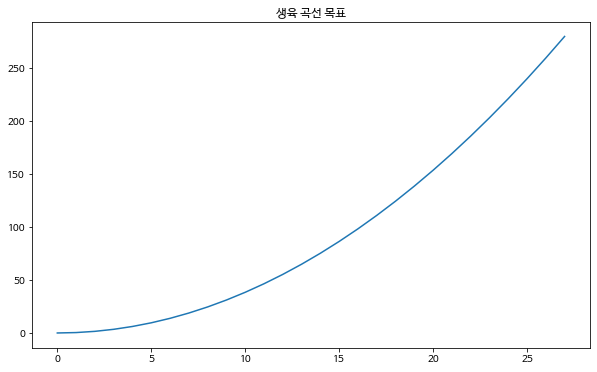

In [94]:
plt.figure(figsize=(10,6))
plt.plot(np.linspace(0, 1, 28)**2 * 280)
plt.title('생육 곡선 목표')
plt.savefig(f'{RESULTS_DIR}생육 곡선 목표.jpg', format='jpg')

### hp_trend()
온도, 습도 등의 환경변화가 자연스럽게 되도록 완만한 곡선을 만드는데 사용된다.

In [13]:
def hp_trend(x, lamb=10):
    hp_cycle, hp_trend = sm.tsa.filters.hpfilter(x, lamb=lamb)
    # Hodrick-Prescott filter
    # 129600(1600*3**4) for monthly data, 1600 for quarterly data, 6.25 (1600/4**4) for annual data
    # Lambda(λ) = 100*(number of periods in a year)^2, ex) Annual data = 100*1^2 = 100 

    return hp_trend

### Optuna 결과 저장
* Optuna의 trial 결과파일을 초기화(삭제)하고, 저장하고, 읽는 함수를 정의한다.

In [14]:
STUDY_TRIAL_HDF = f'{RESULTS_DIR}study_log.hd5'

def reset_study_trials():
    if (os.path.exists(STUDY_TRIAL_HDF)):
        os.remove(STUDY_TRIAL_HDF)
    return

def write_study_trials(study, col):
    df = study.trials_dataframe()
    for n in range(100):
        try:
            key = f'{col}/{n}'
            hdf = pd.read_hdf(STUDY_TRIAL_HDF, key)
        except:
            break
    
    df.to_hdf(STUDY_TRIAL_HDF, key)
    print(f'Saved {key}')
    return

def read_study_trials(col):
    data = []
    for n in range(100):
        try:
            key = f'{col}/{n}'
            hdf = pd.read_hdf(STUDY_TRIAL_HDF, key)
            hdf['trial'] = n
            hdf['pct'] = (hdf['value'] - hdf['value'].min()) / (hdf['value'].max() - hdf['value'].min())
            data.append(hdf)
        except:
            break
    df = pd.concat(data, axis=0).reset_index(drop=True)
    return df

### get_low_high() 함수
* 환경변수가 날짜에 걸쳐 완만히 변화하도록 hp_trend()를 적용한다.

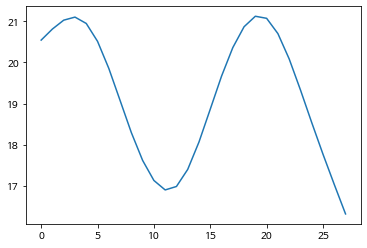

In [102]:
def get_low_high(low_val=[20,22,18,16,20,22,18,16], high_val=[26,24,28,27,26,24,28,26], days=28):
    '''
    low_val과 high_val을 days에 걸쳐 고르게 분포하도록 날짜별 리스트를 만들고, 
    리스트에 있는 수치를 hp_trend()에 의해 완만한 곡선을 이루도록 만들어서 돌려준다.
    '''
    px = 0
    points = np.arange(0, days+1, days//(len(low_val)-1))
    points[-1] = days

    low_vals, high_vals = [], []
    for day in range(days):
        if (day >= points[px]):
            L_0, L_DIF = low_val [px], low_val [px+1] - low_val [px]
            H_0, H_DIF = high_val[px], high_val[px+1] - high_val[px]
            p_days = points[px+1] - points[px]
            p_day = 0
            px += 1
        L_VAL = L_0 + L_DIF * (p_day/p_days)
        H_VAL = H_0 + H_DIF * (p_day/p_days)
        p_day += 1
        low_vals.append(L_VAL)
        high_vals.append(H_VAL)

    low_vals  = hp_trend(low_vals)
    high_vals = hp_trend(high_vals)

    return low_vals, high_vals

low_vals, high_vals = get_low_high()
plt.plot(low_vals)

### 시간당 내부 평균온도: 4도~40도
* 밤에는 온도가 떨어지고 낮에는 온도가 올라가도록 설정한다.
* 0시 ~ start_hour 구간은 low_temp를 적용한다.
* start_hour ~ end_hour 구간은 high_temp를 적용한다.
* end_hour ~ 23시 구간은 low_temp를 적용한다.
* 날짜가 0일에서 27일로 진행함에 따라서 low_temp[0] --> low_temp[1],  high_temp[0] --> high_temp[1]로 바뀌도록 한다.

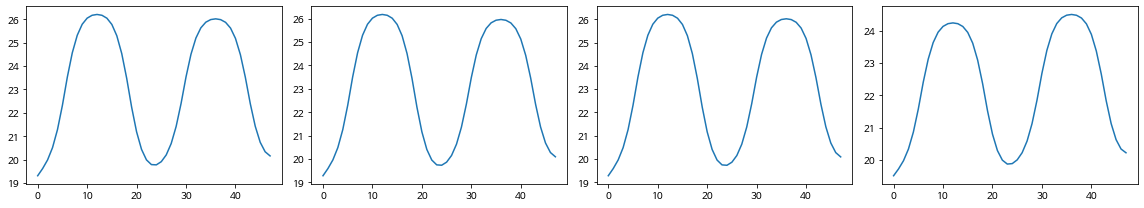

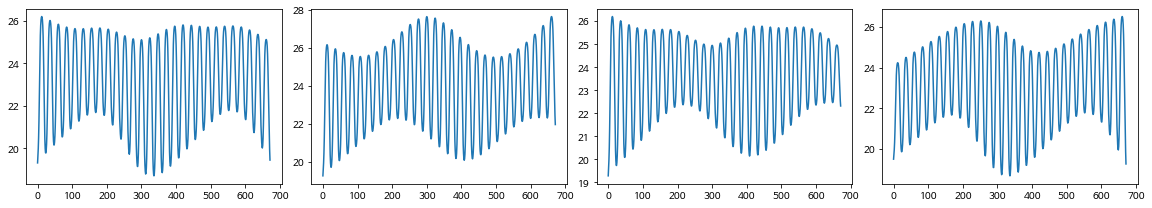

In [103]:
def apply_temperature(start_hour=4, end_hour=23, low_temp=[20,22,18], high_temp=[26,24,28], days=28):
    start_hour = max( 0, start_hour)
    end_hour   = min(23, end_hour)
    end_hour   = end_hour if (end_hour >= start_hour) else start_hour

    low_val   = [max( 4, temp) for temp in low_temp]
    high_val  = [min(40, temp) for temp in high_temp]

    low_vals, high_vals = get_low_high(low_val, high_val, days)

    all_val = np.empty(0)
    for day in range(days):
        arr1 = np.linspace(low_vals [day], low_vals [day], start_hour)
        arr2 = np.linspace(high_vals[day], high_vals[day], end_hour - start_hour + 1)
        arr3 = np.linspace(low_vals [day], low_vals [day], 23 - end_hour)

        all_val = np.concatenate([all_val, arr1, arr2, arr3])

    all_val = hp_trend(all_val)
    return all_val

for day in [2,28]:
    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(16,3))
    PLOT_LEN = 24 * day
    axs[0].plot(apply_temperature(start_hour=6, end_hour=18, low_temp=[20,21,23,18,20,21,23,18], high_temp=[26,25,26,24,26,25,26,24])[:PLOT_LEN])
    axs[1].plot(apply_temperature(start_hour=6, end_hour=18, low_temp=[20,21,23,22,20,21,23,22], high_temp=[26,25,26,28,26,25,26,28])[:PLOT_LEN])
    axs[2].plot(apply_temperature(start_hour=6, end_hour=18, low_temp=[20,21,23,22,20,21,23,22], high_temp=[26,25,26,24,26,25,26,24])[:PLOT_LEN])
    axs[3].plot(apply_temperature(start_hour=6, end_hour=18, low_temp=[20,21,23,18,20,21,23,18], high_temp=[24,25,26,26,24,25,26,26])[:PLOT_LEN])
    plt.tight_layout()
    plt.show()

In [16]:
def objective_temperature(trial, test_x):
    t1 = trial.suggest_int('t1',  0, 10)
    t2 = trial.suggest_int('t2', 18, 24)
    t3 = trial.suggest_int('t3',  4, 23) # (40+4)/2
    t4 = trial.suggest_int('t4',  4, 23)
    t5 = trial.suggest_int('t5',  4, 23)
    t6 = trial.suggest_int('t6',  4, 23)
    t7 = trial.suggest_int('t7',  4, 23)
    t8 = trial.suggest_int('t8',  4, 23)
    t9 = trial.suggest_int('t9',  4, 23)
    ta = trial.suggest_int('ta',  4, 23)
    tb = trial.suggest_int('tb', t3, 41)
    tc = trial.suggest_int('tc', t4, 41)
    td = trial.suggest_int('td', t5, 41)
    te = trial.suggest_int('te', t6, 41)
    tf = trial.suggest_int('tf', t7, 41)
    tg = trial.suggest_int('tg', t8, 41)
    th = trial.suggest_int('th', t9, 41)
    ti = trial.suggest_int('ti', ta, 41)
    test_x['내부온도관측치'] = apply_temperature(start_hour=t1, end_hour=t2, low_temp=[t3,t4,t5,t6,t7,t8,t9,ta], high_temp=[tb,tc,td,te,tf,tg,th,ti])
    w = predict(test_x)
    return w

def study_temperature(test_x, best, keep_best=True, n_trials=100):
    study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=SEED))
    study.optimize(lambda trial: objective_temperature(trial, test_x.copy()), n_trials=n_trials)
    write_study_trials(study, '내부온도관측치')

    if (study.best_trial.value > best) or (keep_best == False):
        best = study.best_trial.value
        print(study.best_trial.value, study.best_trial.params)

        params = study.best_trial.params
        t1, t2, t3, t4, t5, t6, t7, t8, t9, ta, tb, tc, td, te, tf, tg, th, ti = params['t1'], params['t2'], params['t3'], params['t4'], params['t5'], params['t6'], params['t7'], params['t8'], params['t9'], params['ta'], params['tb'], params['tc'], params['td'], params['te'], params['tf'], params['tg'], params['th'], params['ti']
        test_x['내부온도관측치'] = apply_temperature(start_hour=t1, end_hour=t2, low_temp=[t3,t4,t5,t6,t7,t8,t9,ta], high_temp=[tb,tc,td,te,tf,tg,th,ti])
    return test_x, best

# test_x, best = study_temperature(test_x, best)
# test_x['내부온도관측치'].plot()

### 시간당 내부 평균습도: 0% ~ 100%
* 온도가 낮은 밤에는 상대습도가 높아지고, 온도가 높은 낮에는 상대습도가 떨어지도록 설정한다.
* 0시 ~ start_hour 구간은 high_rh를 적용한다.
* start_hour ~ end_hour 구간은 low_rh를 적용한다.
* end_hour ~ 23시 구간은 high_rh를 적용한다.
* 날짜가 0일에서 27일로 진행함에 따라서 low_rh[0] --> low_rh[1],  high_rh[0] --> high_rh[1]로 바뀌도록 한다.

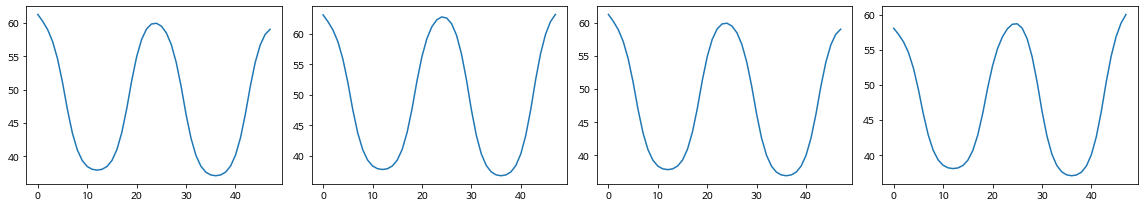

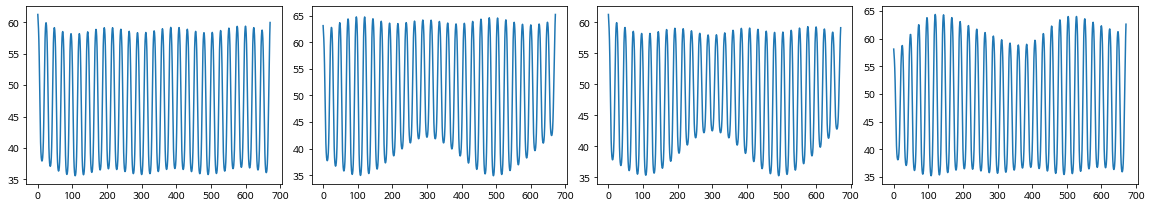

In [104]:
def apply_humidity(start_hour=4, end_hour=23, low_rh=[40,45], high_rh=[60,65], days=28):
    start_hour = max( 0, start_hour)
    end_hour   = min(23, end_hour)
    end_hour   = end_hour if (end_hour >= start_hour) else start_hour

    low_val  = [max(  0, rh) for rh in low_rh]
    high_val = [min(100, rh) for rh in high_rh]

    low_vals, high_vals = get_low_high(low_val, high_val, days)

    all_val = np.empty(0)
    for day in range(days):
        arr1 = np.linspace(high_vals[day], high_vals[day], start_hour)
        arr2 = np.linspace(low_vals [day], low_vals [day], end_hour - start_hour + 1)
        arr3 = np.linspace(high_vals[day], high_vals[day], 23 - end_hour)

        all_val = np.concatenate([all_val, arr1, arr2, arr3])

    all_val = hp_trend(all_val)
    return all_val

for day in [2,28]:
    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(16,3))
    PLOT_LEN = 24 * day
    axs[0].plot(apply_humidity(start_hour=6, end_hour=18, low_rh=[40,35,40,35,40,35,40,35], high_rh=[60,55,60,55,60,55,60,55])[:PLOT_LEN])
    axs[1].plot(apply_humidity(start_hour=6, end_hour=18, low_rh=[40,35,40,45,40,35,40,45], high_rh=[60,65,60,65,60,65,60,65])[:PLOT_LEN])
    axs[2].plot(apply_humidity(start_hour=6, end_hour=18, low_rh=[40,35,40,45,40,35,40,45], high_rh=[60,55,60,55,60,55,60,55])[:PLOT_LEN])
    axs[3].plot(apply_humidity(start_hour=6, end_hour=18, low_rh=[40,35,40,35,40,35,40,35], high_rh=[55,65,60,60,55,65,60,60])[:PLOT_LEN])
    plt.tight_layout()
    plt.show()

In [18]:
def objective_humidity(trial, test_x):
    h1 = trial.suggest_int('h1',  0, 10)
    h2 = trial.suggest_int('h2', 18, 24)
    h3 = trial.suggest_int('h3',  0, 71)
    h4 = trial.suggest_int('h4',  0, 71)
    h5 = trial.suggest_int('h5',  0, 71)
    h6 = trial.suggest_int('h6',  0, 71)
    h7 = trial.suggest_int('h7',  0, 71)
    h8 = trial.suggest_int('h8',  0, 71)
    h9 = trial.suggest_int('h9',  0, 71)
    ha = trial.suggest_int('ha',  0, 71)
    hb = trial.suggest_int('hb', h3,101)
    hc = trial.suggest_int('hc', h4,101)
    hd = trial.suggest_int('hd', h5,101)
    he = trial.suggest_int('he', h6,101)
    hf = trial.suggest_int('hf', h7,101)
    hg = trial.suggest_int('hg', h8,101)
    hh = trial.suggest_int('hh', h9,101)
    hi = trial.suggest_int('hi', ha,101)

    test_x['내부습도관측치'] = apply_humidity(start_hour=h1, end_hour=h2, low_rh=[h3,h4,h5,h6,h7,h8,h9,ha], high_rh=[hb,hc,hd,he,hf,hg,hh,hi])
    w = predict(test_x)
    return w

def study_humidity(test_x, best, keep_best=True, n_trials=100):
    study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=SEED))
    study.optimize(lambda trial: objective_humidity(trial, test_x.copy()), n_trials=n_trials)
    write_study_trials(study, '내부습도관측치')

    if (study.best_trial.value > best) or (keep_best == False):
        best = study.best_trial.value
        print(study.best_trial.value, study.best_trial.params)

        params = study.best_trial.params
        h1, h2, h3,h4,h5,h6,h7,h8,h9,ha, hb,hc,hd,he,hf,hg,hh,hi = params['h1'], params['h2'], params['h3'], params['h4'], params['h5'], params['h6'], params['h7'], params['h8'], params['h9'], params['ha'], params['hb'], params['hc'], params['hd'], params['he'], params['hf'], params['hg'], params['hh'], params['hi']
        test_x['내부습도관측치'] = apply_humidity(start_hour=h1, end_hour=h2, low_rh=[h3,h4,h5,h6,h7,h8,h9,ha], high_rh=[hb,hc,hd,he,hf,hg,hh,hi])
    return test_x, best

# test_x, best = study_humidity(test_x, best)
# test_x['내부습도관측치'].plot()

### 시간당 분무량 : 0 ~ 3000 / 일간 누적 분무량 0 ~ 72,000
* 분무는 사전에 정해진 수분부족분(HD)과 습도(RH)와 온도에 의해서 결정될 것으로 추측된다.
* 하지만 여기에서는 그러한 정보를 알 수 없기 때문에 단순히 분무에 의해 공기중의 수분량이 변화할 것으로 보고 시뮬레이션을 한다.
* 분무량을 결정하는 미지의 요인을 alpha, beta, gamma, delta, theta로 가정한다.
* 공기 중의 수분량인 spray가 alpha이하가 되면 3000 이내에서 (beta * gamma)/delta 만큼 증가시킨다.
* 수분량이 부족하지 않으면 매 시간 theta 만큼 수분량이 감소하는 것으로 한다.

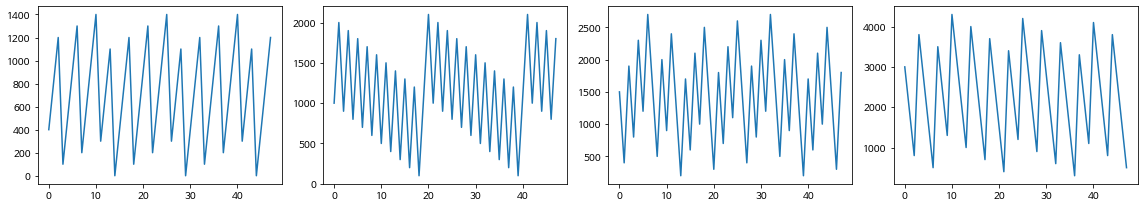

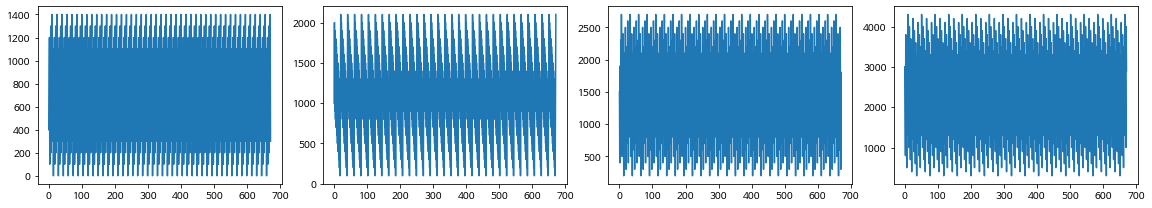

In [19]:
def apply_spray(alpha=1000, beta=1500, gamma=1, delta=1, theta=1000, days=28, debug=False):
    all_spray = []  # 분무량

    spray = water = 0
    for n in range(24*days):
        if (spray < alpha):
            water = min(3000, beta * gamma) / delta
            spray = spray + water
        else:
            spray -= theta
        spray = max(0, spray)

        all_spray.append(spray)

        if (debug):
            print(f'{n:3d} {water:8.2f} {spray:8.2f}')
            if (n>10):
                break
            
    return all_spray

for day in [2,28]:
    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(16,3))
    PLOT_LEN = 24 * day
    axs[0].plot(apply_spray(alpha=1100, beta=1600, gamma=1, delta=4, theta=1100)[:PLOT_LEN])
    axs[1].plot(apply_spray(alpha=1200, beta=1500, gamma=2, delta=3, theta=1100)[:PLOT_LEN])
    axs[2].plot(apply_spray(alpha=1300, beta=1400, gamma=3, delta=2, theta=1100)[:PLOT_LEN])
    axs[3].plot(apply_spray(alpha=1400, beta=1300, gamma=4, delta=1, theta=1100)[:PLOT_LEN])
    plt.tight_layout()
    plt.show()

In [20]:
def objective_spray(trial, test_x):
    alpha = trial.suggest_categorical('alpha', np.arange(500, 2001, 100))
    beta  = trial.suggest_categorical('beta' , np.arange(500, 2001, 100))
    gamma = trial.suggest_categorical('gamma', np.arange(1, 10))
    delta = trial.suggest_categorical('delta', np.arange(1, 10))
    theta = trial.suggest_categorical('theta', np.arange(500, 2001, 100))

    test_x['시간당분무량'] = apply_spray(alpha=alpha, beta=beta, gamma=gamma, delta=delta, theta=theta)
    w = predict(test_x)
    return w

def study_spray(test_x, best, keep_best=True, n_trials=100):
    study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=SEED))
    study.optimize(lambda trial: objective_spray(trial, test_x.copy()), n_trials=n_trials)
    write_study_trials(study, '시간당분무량')

    if (study.best_trial.value > best) or (keep_best == False):
        best = study.best_trial.value
        print(study.best_trial.value, study.best_trial.params)

        params = study.best_trial.params
        alpha, beta, gamma, delta, theta = params['alpha'], params['beta'], params['gamma'], params['delta'], params['theta']
        test_x['시간당분무량'] = apply_spray(alpha=alpha, beta=beta, gamma=gamma, delta=delta, theta=theta)
    return test_x, best

# test_x, best = study_spray(test_x, best)
# test_x['시간당분무량'].plot()

### 시간당 내부 평균 co2 농도 : 0ppm ~ 1200 ppm
* 일반적인 온실환경은 밤에 co2가 높아지고 낮에 co2가 낮아지는 변화를 보인다.
* 하지만 co2시설이 있는 경우에는 광합성이 활발한 낮에 co2를 공급해 주기 때문에 반대로 낮에 co2가 높아지게 된다.
* 0시 ~ start_hour 구간은 low_co2를 적용한다.
* start_hour ~ end_hour 구간은 high_co2를 적용한다.
* end_hour ~ 23시 구간은 low_co2를 적용한다.
* 날짜가 0일에서 27일로 진행함에 따라서 low_co2[0] --> low_co2[1],  high_co2[0] --> high_co2[1]로 바뀌도록 한다.

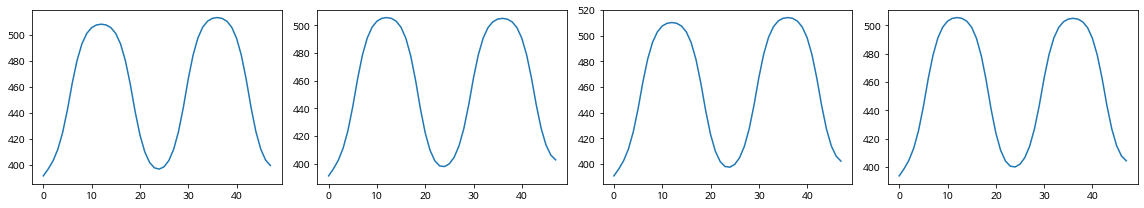

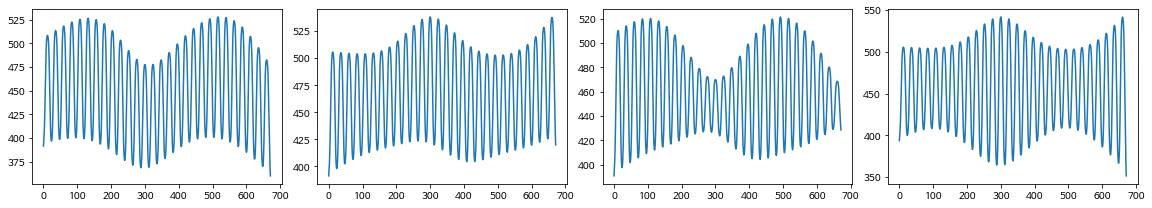

In [105]:
def apply_co2(start_hour=4, end_hour=23, low_co2=[400,420], high_co2=[500,520], days=28):
    start_hour = max( 0, start_hour)
    end_hour   = min(23, end_hour)
    end_hour   = end_hour if (end_hour >= start_hour) else start_hour

    low_val  = [max(   0, co2) for co2 in low_co2]
    high_val = [min(1200, co2) for co2 in high_co2]

    low_vals, high_vals = get_low_high(low_val, high_val, days)

    all_val = np.empty(0)
    for day in range(days):
        arr1 = np.linspace(low_vals [day], low_vals [day], start_hour)
        arr2 = np.linspace(high_vals[day], high_vals[day], end_hour - start_hour + 1)
        arr3 = np.linspace(low_vals [day], low_vals [day], 23 - end_hour)

        all_val = np.concatenate([all_val, arr1, arr2, arr3])

    all_val = hp_trend(all_val)
    return all_val

for day in [2,28]:
    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(16,3))
    PLOT_LEN = 24 * day
    axs[0].plot(apply_co2(start_hour=6, end_hour=18, low_co2=[400,410,400,360,400,410,400,360], high_co2=[500,520,520,450,500,520,520,450])[:PLOT_LEN])
    axs[1].plot(apply_co2(start_hour=6, end_hour=18, low_co2=[400,420,420,440,400,420,420,440], high_co2=[500,500,500,550,500,500,500,550])[:PLOT_LEN])
    axs[2].plot(apply_co2(start_hour=6, end_hour=18, low_co2=[400,420,420,440,400,420,420,440], high_co2=[500,520,500,450,500,520,500,450])[:PLOT_LEN])
    axs[3].plot(apply_co2(start_hour=6, end_hour=18, low_co2=[400,420,400,360,400,420,400,360], high_co2=[500,500,500,550,500,500,500,550])[:PLOT_LEN])
    plt.tight_layout()
    plt.show()

In [22]:
def objective_co2(trial, test_x):
    c1 = trial.suggest_int('c1',  0, 10)
    c2 = trial.suggest_int('c2', 18, 24)
    c3 = trial.suggest_int('c3',   0,  421, 20)
    c4 = trial.suggest_int('c4',   0,  421, 20)
    c5 = trial.suggest_int('c5',   0,  421, 20)
    c6 = trial.suggest_int('c6',   0,  421, 20)
    c7 = trial.suggest_int('c7',   0,  421, 20)
    c8 = trial.suggest_int('c8',   0,  421, 20)
    c9 = trial.suggest_int('c9',   0,  421, 20)
    ca = trial.suggest_int('ca',   0,  421, 20)
    cb = trial.suggest_int('cb',  c3, 1201, 20)
    cc = trial.suggest_int('cc',  c4, 1201, 20)
    cd = trial.suggest_int('cd',  c5, 1201, 20)
    ce = trial.suggest_int('ce',  c6, 1201, 20)
    cf = trial.suggest_int('cf',  c7, 1201, 20)
    cg = trial.suggest_int('cg',  c8, 1201, 20)
    ch = trial.suggest_int('ch',  c9, 1201, 20)
    ci = trial.suggest_int('ci',  ca, 1201, 20)

    test_x['co2관측치'] = apply_co2(start_hour=c1, end_hour=c2, low_co2=[c3,c4,c5,c6,c7,c8,c9,ca], high_co2=[cb,cc,cd,ce,cf,cg,ch,ci])

    w = predict(test_x)
    return w

def study_co2(test_x, best, keep_best=True, n_trials=100):
    study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=SEED))
    study.optimize(lambda trial: objective_co2(trial, test_x.copy()), n_trials=n_trials)
    write_study_trials(study, 'co2관측치')

    if (study.best_trial.value > best) or (keep_best == False):
        best = study.best_trial.value
        print(study.best_trial.value, study.best_trial.params)

        params = study.best_trial.params
        c1, c2, c3,c4,c5,c6,c7,c8,c9,ca, cb,cc,cd,ce,cf,cg,ch,ci = params['c1'], params['c2'], params['c3'], params['c4'], params['c5'], params['c6'], params['c7'], params['c8'], params['c9'], params['ca'], params['cb'], params['cc'], params['cd'], params['ce'], params['cf'], params['cg'], params['ch'], params['ci']
        test_x['co2관측치'] = apply_co2(start_hour=c1, end_hour=c2, low_co2=[c3,c4,c5,c6,c7,c8,c9,ca], high_co2=[cb,cc,cd,ce,cf,cg,ch,ci])
    return test_x, best

# test_x, best = study_co2(test_x, best)
# test_x['co2관측치'].plot()

### 시간당 평균 EC : 0 ~ 8
* EC는 양액을 공급하는 시점에 높아졌다가 식물이 양분을 흡수하게 되면 낮아지게 된다.
* 일반적으로 일출 1~2시간 후 광합성이 활발하게 진행되는 시점에 양액을 공급하는 것이 적당하다고 알려져 있다.
* 0시 ~ start_hour 구간은 low_ec를 적용한다.
* start_hour ~ end_hour 구간은 high_ec를 적용한다.
* end_hour ~ 23시 구간은 low_ec를 적용한다.
* 날짜가 0일에서 27일로 진행함에 따라서 low_ec[0] --> low_ec[1],  high_ec[0] --> high_ec[1]로 바뀌도록 한다.
* low에 높은 값이 지정되고, high에 낮은 값이 지정되면 고ec > 저ec > 고ec 순으로 변화하게 된다.

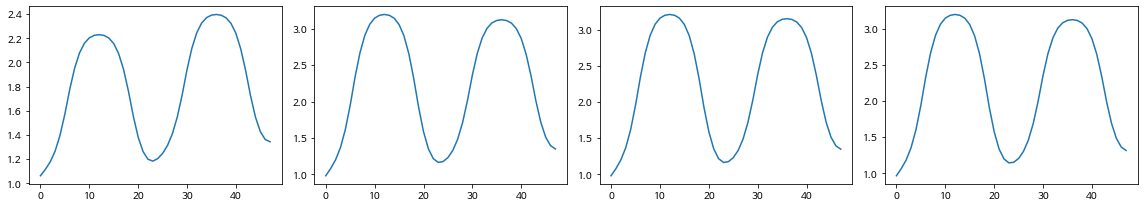

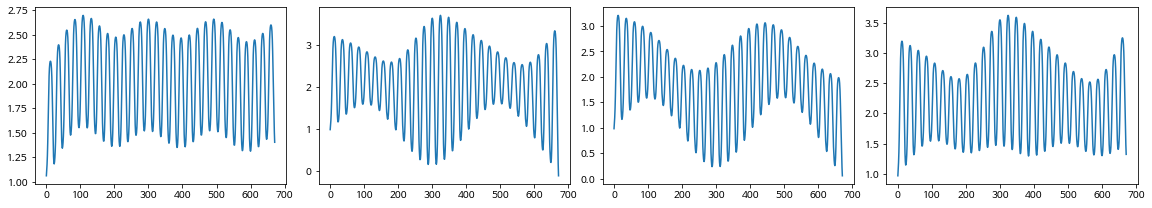

In [106]:
def apply_ec(start_hour=4, end_hour=23, low_ec=[0,2], high_ec=[2,3], days=28):
    start_hour = max( 0, start_hour)
    end_hour   = min(23, end_hour)
    end_hour   = end_hour if (end_hour >= start_hour) else start_hour

    low_val  = [max(0, ec) for ec in low_ec]
    high_val = [min(8, ec) for ec in high_ec]

    low_vals, high_vals = get_low_high(low_val, high_val, days)

    all_val = np.empty(0)
    for day in range(days):
        arr1 = np.linspace(low_vals [day], low_vals [day], start_hour)
        arr2 = np.linspace(high_vals[day], high_vals[day], end_hour - start_hour + 1)
        arr3 = np.linspace(low_vals [day], low_vals [day], 23 - end_hour)

        all_val = np.concatenate([all_val, arr1, arr2, arr3])

    all_val = hp_trend(all_val)
    return all_val

for day in [2,28]:
    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(16,3))
    PLOT_LEN = 24 * day
    axs[0].plot(apply_ec(start_hour=6, end_hour=18, low_ec=[1,2,1,2,1,2,1,2], high_ec=[2,3,2,3,2,3,2,3])[:PLOT_LEN])
    axs[1].plot(apply_ec(start_hour=6, end_hour=18, low_ec=[1,2,1,0,1,2,1,0], high_ec=[3,3,2,4,3,3,2,4])[:PLOT_LEN])
    axs[2].plot(apply_ec(start_hour=6, end_hour=18, low_ec=[1,2,1,0,1,2,1,0], high_ec=[3,3,2,2,3,3,2,2])[:PLOT_LEN])
    axs[3].plot(apply_ec(start_hour=6, end_hour=18, low_ec=[1,2,1,2,1,2,1,2], high_ec=[3,3,2,4,3,3,2,4])[:PLOT_LEN])
    plt.tight_layout()
    plt.show()

In [24]:
def objective_ec(trial, test_x):
    e1 = trial.suggest_int('e1',  0, 12)
    e2 = trial.suggest_int('e2', 12, 24)
    e3 = trial.suggest_int('e3',  0,  8)
    e4 = trial.suggest_int('e4',  0,  8)
    e5 = trial.suggest_int('e5',  0,  8)
    e6 = trial.suggest_int('e6',  0,  8)
    e7 = trial.suggest_int('e7',  0,  8)
    e8 = trial.suggest_int('e8',  0,  8)
    e9 = trial.suggest_int('e9',  0,  8)
    ea = trial.suggest_int('ea',  0,  8)
    eb = trial.suggest_int('eb', e3,  9)
    ec = trial.suggest_int('ec', e4,  9)
    ed = trial.suggest_int('ed', e5,  9)
    ee = trial.suggest_int('ee', e6,  9)
    ef = trial.suggest_int('ef', e7,  9)
    eg = trial.suggest_int('eg', e8,  9)
    eh = trial.suggest_int('eh', e9,  9)
    ei = trial.suggest_int('ei', ea,  9)

    test_x['ec관측치'] = apply_ec(start_hour=e1, end_hour=e2, low_ec=[e3,e4,e5,e6,e7,e8,e9,ea], high_ec=[eb,ec,ed,ee,ef,eg,eh,ei])

    w = predict(test_x)
    return w

def study_ec(test_x, best, keep_best=True, n_trials=100):
    study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=SEED))
    study.optimize(lambda trial: objective_ec(trial, test_x.copy()), n_trials=n_trials)
    write_study_trials(study, 'ec관측치')

    if (study.best_trial.value > best) or (keep_best == False):
        best = study.best_trial.value
        print(study.best_trial.value, study.best_trial.params)

        params = study.best_trial.params
        e1, e2, e3,e4,e5,e6,e7,e8,e9,ea, eb,ec,ed,ee,ef,eg,eh,ei = params['e1'], params['e2'], params['e3'], params['e4'], params['e5'], params['e6'], params['e7'], params['e8'], params['e9'], params['ea'], params['eb'], params['ec'], params['ed'], params['ee'], params['ef'], params['eg'], params['eh'], params['ei']
        test_x['ec관측치'] = apply_ec(start_hour=e1, end_hour=e2, low_ec=[e3,e4,e5,e6,e7,e8,e9,ea], high_ec=[eb,ec,ed,ee,ef,eg,eh,ei])
    return test_x, best

# best_x, best = study_ec(best_x, best)
# test_x['ec관측치'].plot()

### 시간당 광량: 0 ~ 120,000 / 일간 누적 광량 0 ~ 2,880,000
* 다른 환경변수와 달리 광량은 불을 켜겨나 끄는 것을 나타내기 위해 곡선형태로 변경하지 않는다.
* 또한, low_light는 항상 0이 되도록 하고, 백색, 적색, 청색의 최대광량을 40000으로 해서 3개의 합이 최대 120,000이 되도록 한다.
* 0시 ~ start_hour 구간은 low_light를 적용한다.
* Start_hour ~ end_hour 구간은 high_light를 적용한다.
* End_hour ~ 23시 구간은 low_light를 적용한다.
* 날짜가 0일에서 27일로 진행함에 따라서 low_light[0] --> low_light[1], high_light[0] --> high_light[1]로 바뀌도록 한다.

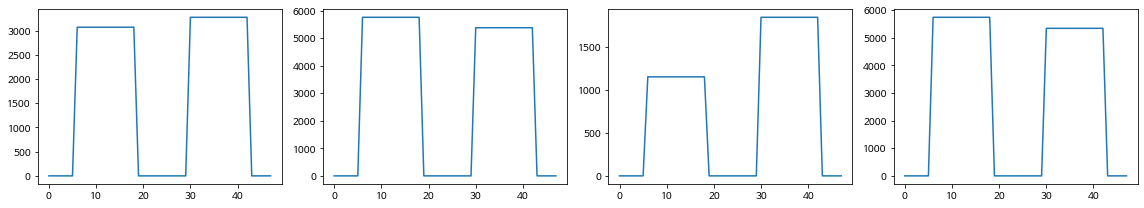

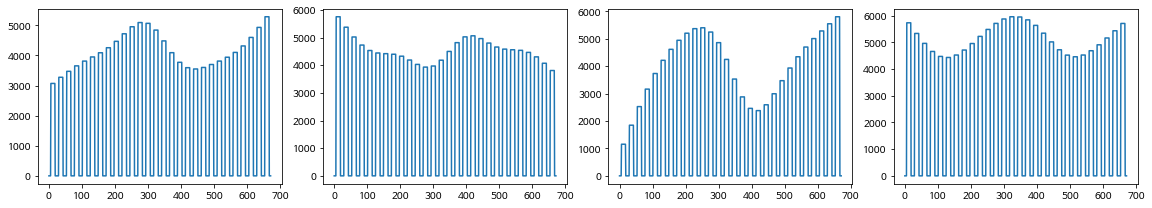

In [107]:
def apply_lights(start_hour=4, end_hour=23, low_light=[0,0], high_light=[3000,6000], days=28):
    start_hour = max( 0, start_hour)
    end_hour   = min(23, end_hour)
    end_hour   = end_hour if (end_hour >= start_hour) else start_hour

    low_val  = [max(    0, light) for light in low_light]
    high_val = [min(40000, light) for light in high_light]

    low_vals, high_vals = get_low_high(low_val, high_val, days)

    all_val = np.empty(0)
    for day in range(days):
        arr1 = np.linspace(low_vals [day], low_vals [day], start_hour)
        arr2 = np.linspace(high_vals[day], high_vals[day], end_hour - start_hour + 1)
        arr3 = np.linspace(low_vals [day], low_vals [day], 23 - end_hour)

        all_val = np.concatenate([all_val, arr1, arr2, arr3])

    # all_val = hp_trend(all_val)
    return all_val

for day in [2,28]:
    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(16,3))
    PLOT_LEN = 24 * day
    axs[0].plot(apply_lights(start_hour=6, end_hour=18, low_light=[0,0,0,0,0,0,0,0], high_light=[3000,4000,4000,6000,3000,4000,4000,6000])[:PLOT_LEN])
    axs[1].plot(apply_lights(start_hour=6, end_hour=18, low_light=[0,0,0,0,0,0,0,0], high_light=[6000,4000,5000,3000,6000,4000,5000,3000])[:PLOT_LEN])
    axs[2].plot(apply_lights(start_hour=6, end_hour=18, low_light=[0,0,0,0,0,0,0,0], high_light=[1000,4000,5000,6000,1000,4000,5000,6000])[:PLOT_LEN])
    axs[3].plot(apply_lights(start_hour=6, end_hour=18, low_light=[0,0,0,0,0,0,0,0], high_light=[6000,4000,5000,6000,6000,4000,5000,6000])[:PLOT_LEN])
    plt.tight_layout()
    plt.show()

In [26]:
def objective_white(trial, test_x):
    w1 = trial.suggest_int(f'w1',  0, 10)
    w2 = trial.suggest_int(f'w2', 18, 24)
    w3 = trial.suggest_int(f'w3',  0, 40001, 2000)
    w4 = trial.suggest_int(f'w4',  0, 40001, 2000)
    w5 = trial.suggest_int(f'w5',  0, 40001, 2000)
    w6 = trial.suggest_int(f'w6',  0, 40001, 2000)
    w7 = trial.suggest_int(f'w7',  0, 40001, 2000)
    w8 = trial.suggest_int(f'w8',  0, 40001, 2000)
    w9 = trial.suggest_int(f'w9',  0, 40001, 2000)
    wa = trial.suggest_int(f'wa',  0, 40001, 2000)

    test_x['시간당백색광량'] = apply_lights(start_hour=w1, end_hour=w2, low_light=[0,0,0,0,0,0,0,0], high_light=[w3,w4,w5,w6,w7,w8,w9,wa])
    w = predict(test_x)
    return w

def study_white(test_x, best, keep_best=True, n_trials=100):
    study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=SEED))
    study.optimize(lambda trial: objective_white(trial, test_x.copy()), n_trials=n_trials)
    write_study_trials(study, '시간당백색광량')

    if (study.best_trial.value > best) or (keep_best == False):
        best = study.best_trial.value
        print(study.best_trial.value, study.best_trial.params)

        params = study.best_trial.params
        w1, w2, w3, w4, w5, w6, w7, w8, w9, wa = params['w1'], params['w2'], params['w3'], params['w4'], params['w5'], params['w6'], params['w7'], params['w8'], params['w9'], params['wa']
        test_x['시간당백색광량'] = apply_lights(start_hour=w1, end_hour=w2, low_light=[0,0,0,0,0,0,0,0], high_light=[w3,w4,w5,w6,w7,w8,w9,wa])
    return test_x, best

# test_x, best = study_white(test_x, best)
# test_x['시간당백색광량'].plot()

In [27]:
def objective_red(trial, test_x):
    r1 = trial.suggest_int(f'r1',  0, 10)
    r2 = trial.suggest_int(f'r2', 18, 24)
    r3 = trial.suggest_int(f'r3',  0, 40001, 2000)
    r4 = trial.suggest_int(f'r4',  0, 40001, 2000)
    r5 = trial.suggest_int(f'r5',  0, 40001, 2000)
    r6 = trial.suggest_int(f'r6',  0, 40001, 2000)
    r7 = trial.suggest_int(f'r7',  0, 40001, 2000)
    r8 = trial.suggest_int(f'r8',  0, 40001, 2000)
    r9 = trial.suggest_int(f'r9',  0, 40001, 2000)
    ra = trial.suggest_int(f'ra',  0, 40001, 2000)

    test_x['시간당적색광량'] = apply_lights(start_hour=r1, end_hour=r2, low_light=[0,0,0,0,0,0,0,0], high_light=[r3,r4,r5,r6,r7,r8,r9,ra])
    w = predict(test_x)
    return w

def study_red(test_x, best, keep_best=True, n_trials=100):
    study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=SEED))
    study.optimize(lambda trial: objective_red(trial, test_x.copy()), n_trials=n_trials)
    write_study_trials(study, '시간당적색광량')

    if (study.best_trial.value > best) or (keep_best == False):
        best = study.best_trial.value
        print(study.best_trial.value, study.best_trial.params)

        params = study.best_trial.params
        r1, r2, r3, r4, r5, r6, r7, r8, r9, ra = params['r1'], params['r2'], params['r3'], params['r4'], params['r5'], params['r6'], params['r7'], params['r8'], params['r9'], params['ra']
        test_x['시간당적색광량'] = apply_lights(start_hour=r1, end_hour=r2, low_light=[0,0,0,0,0,0,0,0], high_light=[r3,r4,r5,r6,r7,r8,r9,ra])
    return test_x, best

# test_x, best = study_red(test_x, best)
# test_x['시간당적색광량'].plot()

In [28]:
def objective_blue(trial, test_x):
    b1 = trial.suggest_int(f'b1',  0, 10)
    b2 = trial.suggest_int(f'b2', 18, 24)
    b3 = trial.suggest_int(f'b3',  0, 40001, 2000)
    b4 = trial.suggest_int(f'b4',  0, 40001, 2000)
    b5 = trial.suggest_int(f'b5',  0, 40001, 2000)
    b6 = trial.suggest_int(f'b6',  0, 40001, 2000)
    b7 = trial.suggest_int(f'b7',  0, 40001, 2000)
    b8 = trial.suggest_int(f'b8',  0, 40001, 2000)
    b9 = trial.suggest_int(f'b9',  0, 40001, 2000)
    ba = trial.suggest_int(f'ba',  0, 40001, 2000)

    test_x['시간당청색광량'] = apply_lights(start_hour=b1, end_hour=b2, low_light=[0,0,0,0,0,0,0,0], high_light=[b3,b4,b5,b6,b7,b8,b9,ba])
    w = predict(test_x)
    return w

def study_blue(test_x, best, keep_best=True, n_trials=100):
    study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=SEED))
    study.optimize(lambda trial: objective_blue(trial, test_x.copy()), n_trials=n_trials)
    write_study_trials(study, '시간당청색광량')

    if (study.best_trial.value > best) or (keep_best == False):
        best = study.best_trial.value
        print(study.best_trial.value, study.best_trial.params)

        params = study.best_trial.params
        b1, b2, b3, b4, b5, b6, b7, b8, b9, ba = params['b1'], params['b2'], params['b3'], params['b4'], params['b5'], params['b6'], params['b7'], params['b8'], params['b9'], params['ba']
        test_x['시간당청색광량'] = apply_lights(start_hour=b1, end_hour=b2, low_light=[0,0,0,0,0,0,0,0], high_light=[b3,b4,b5,b6,b7,b8,b9,ba])
    return test_x, best

# test_x, best = study_blue(test_x, best)
# test_x['시간당청색광량'].plot()

In [108]:
reset_study_trials()
best_x = min_x.copy()
prev_best = best = predict(best_x)

optuna.logging.set_verbosity(optuna.logging.INFO)
for n in range(10):
    best_x, best = study_temperature(best_x, best)
    best_x, best = study_humidity   (best_x, best)
    best_x, best = study_spray      (best_x, best)
    best_x, best = study_co2        (best_x, best)
    best_x, best = study_ec         (best_x, best)
    best_x, best = study_white      (best_x, best)
    best_x, best = study_red        (best_x, best)
    best_x, best = study_blue       (best_x, best)
    print(f'>>>>>>>>>>>>>> Epoch: {n+1}/10  Best: {best:.3f} <<<<<<<<<<<<<<<<<<<')

    if (best <= prev_best):
        break
    prev_best = best

[I 2022-12-22 05:33:13,746] A new study created in memory with name: no-name-b20fd6f7-5b6b-4472-9bc3-5601bee633c8
[I 2022-12-22 05:33:15,075] Trial 0 finished with value: -0.6648232051632639 and parameters: {'t1': 4, 't2': 24, 't3': 18, 't4': 15, 't5': 7, 't6': 7, 't7': 5, 't8': 21, 't9': 16, 'ta': 18, 'tb': 18, 'tc': 41, 'td': 36, 'te': 14, 'tf': 11, 'tg': 24, 'th': 23, 'ti': 30}. Best is trial 0 with value: -0.6648232051632639.
[I 2022-12-22 05:33:16,384] Trial 1 finished with value: -0.8564434659738431 and parameters: {'t1': 4, 't2': 20, 't3': 16, 't4': 6, 't5': 9, 't6': 11, 't7': 13, 't8': 19, 't9': 7, 'ta': 14, 'tb': 31, 'tc': 7, 'td': 29, 'te': 16, 'tf': 14, 'tg': 40, 'th': 40, 'ti': 36}. Best is trial 0 with value: -0.6648232051632639.
[I 2022-12-22 05:33:17,643] Trial 2 finished with value: -0.8551019198456469 and parameters: {'t1': 3, 't2': 18, 't3': 17, 't4': 12, 't5': 6, 't6': 13, 't7': 4, 't8': 22, 't9': 9, 'ta': 17, 'tb': 24, 'tc': 27, 'td': 25, 'te': 18, 'tf': 40, 'tg': 3

Saved 내부온도관측치/0
-0.5798549984437398 {'t1': 6, 't2': 24, 't3': 6, 't4': 18, 't5': 15, 't6': 22, 't7': 5, 't8': 15, 't9': 7, 'ta': 7, 'tb': 41, 'tc': 22, 'td': 41, 'te': 36, 'tf': 31, 'tg': 16, 'th': 26, 'ti': 9}


[I 2022-12-22 05:35:36,022] Trial 0 finished with value: -0.9411083041360908 and parameters: {'h1': 4, 'h2': 24, 'h3': 52, 'h4': 43, 'h5': 11, 'h6': 11, 'h7': 4, 'h8': 62, 'h9': 43, 'ha': 50, 'hb': 53, 'hc': 100, 'hd': 86, 'he': 30, 'hf': 21, 'hg': 69, 'hh': 60, 'hi': 77}. Best is trial 0 with value: -0.9411083041360908.
[I 2022-12-22 05:35:37,264] Trial 1 finished with value: -0.9429594027140256 and parameters: {'h1': 4, 'h2': 20, 'h3': 44, 'h4': 10, 'h5': 21, 'h6': 26, 'h7': 32, 'h8': 56, 'h9': 14, 'ha': 37, 'hb': 78, 'hc': 14, 'hd': 70, 'he': 38, 'hf': 36, 'hg': 99, 'hh': 98, 'hi': 89}. Best is trial 0 with value: -0.9411083041360908.
[I 2022-12-22 05:35:38,509] Trial 2 finished with value: -0.904360982198479 and parameters: {'h1': 3, 'h2': 18, 'h3': 49, 'h4': 31, 'h5': 8, 'h6': 35, 'h7': 2, 'h8': 65, 'h9': 18, 'ha': 47, 'hb': 65, 'hc': 67, 'hd': 59, 'he': 47, 'hf': 98, 'hg': 93, 'hh': 96, 'hi': 96}. Best is trial 2 with value: -0.904360982198479.
[I 2022-12-22 05:35:40,050] Trial 3

Saved 내부습도관측치/0
-0.22581239996160463 {'h1': 10, 'h2': 18, 'h3': 43, 'h4': 33, 'h5': 62, 'h6': 54, 'h7': 63, 'h8': 71, 'h9': 71, 'ha': 38, 'hb': 91, 'hc': 94, 'hd': 101, 'he': 93, 'hf': 98, 'hg': 73, 'hh': 82, 'hi': 57}


[I 2022-12-22 05:37:55,338] Trial 0 finished with value: 0.20011310175289632 and parameters: {'alpha': 1600, 'beta': 1400, 'gamma': 3, 'delta': 3, 'theta': 500}. Best is trial 0 with value: 0.20011310175289632.
[I 2022-12-22 05:37:56,635] Trial 1 finished with value: -0.11219401454975864 and parameters: {'alpha': 800, 'beta': 1100, 'gamma': 7, 'delta': 6, 'theta': 1000}. Best is trial 0 with value: 0.20011310175289632.
[I 2022-12-22 05:37:57,874] Trial 2 finished with value: 0.20443452824338115 and parameters: {'alpha': 1200, 'beta': 1100, 'gamma': 2, 'delta': 6, 'theta': 500}. Best is trial 2 with value: 0.20443452824338115.
[I 2022-12-22 05:37:59,197] Trial 3 finished with value: -0.06684067131617266 and parameters: {'alpha': 1000, 'beta': 1700, 'gamma': 1, 'delta': 9, 'theta': 1800}. Best is trial 2 with value: 0.20443452824338115.
[I 2022-12-22 05:38:00,432] Trial 4 finished with value: 0.11450524819805774 and parameters: {'alpha': 1400, 'beta': 500, 'gamma': 1, 'delta': 1, 'theta'

Saved 시간당분무량/0
0.22324016667179547 {'alpha': 1600, 'beta': 700, 'gamma': 3, 'delta': 3, 'theta': 900}


[I 2022-12-22 05:40:08,295] Trial 0 finished with value: 0.2775805810900258 and parameters: {'c1': 4, 'c2': 24, 'c3': 320, 'c4': 260, 'c5': 60, 'c6': 60, 'c7': 20, 'c8': 380, 'c9': 260, 'ca': 300, 'cb': 320, 'cc': 1180, 'cd': 1020, 'ce': 300, 'cf': 220, 'cg': 520, 'ch': 540, 'ci': 780}. Best is trial 0 with value: 0.2775805810900258.
[I 2022-12-22 05:40:09,610] Trial 1 finished with value: 0.21446966116002053 and parameters: {'c1': 4, 'c2': 20, 'c3': 260, 'c4': 60, 'c5': 120, 'c6': 160, 'c7': 200, 'c8': 340, 'c9': 80, 'ca': 220, 'cb': 820, 'cc': 100, 'cd': 780, 'ce': 340, 'cf': 260, 'cg': 1160, 'ch': 1180, 'ci': 1020}. Best is trial 0 with value: 0.2775805810900258.
[I 2022-12-22 05:40:11,058] Trial 2 finished with value: 0.19888119857776998 and parameters: {'c1': 3, 'c2': 18, 'c3': 300, 'c4': 180, 'c5': 40, 'c6': 200, 'c7': 0, 'c8': 400, 'c9': 100, 'ca': 280, 'cb': 580, 'cc': 720, 'cd': 680, 'ce': 380, 'cf': 1180, 'cg': 1020, 'ch': 1140, 'ci': 1120}. Best is trial 0 with value: 0.2775

Saved co2관측치/0
0.4133423865027108 {'c1': 1, 'c2': 20, 'c3': 140, 'c4': 420, 'c5': 300, 'c6': 160, 'c7': 80, 'c8': 320, 'c9': 240, 'ca': 0, 'cb': 580, 'cc': 840, 'cd': 440, 'ce': 240, 'cf': 340, 'cg': 360, 'ch': 340, 'ci': 20}


[I 2022-12-22 05:42:28,016] Trial 0 finished with value: 0.49310418640248765 and parameters: {'e1': 4, 'e2': 24, 'e3': 6, 'e4': 5, 'e5': 1, 'e6': 1, 'e7': 0, 'e8': 7, 'e9': 5, 'ea': 6, 'eb': 6, 'ec': 9, 'ed': 8, 'ee': 2, 'ef': 1, 'eg': 7, 'eh': 6, 'ei': 8}. Best is trial 0 with value: 0.49310418640248765.
[I 2022-12-22 05:42:29,251] Trial 1 finished with value: 0.493536094767111 and parameters: {'e1': 5, 'e2': 15, 'e3': 5, 'e4': 1, 'e5': 2, 'e6': 3, 'e7': 4, 'e8': 7, 'e9': 1, 'ea': 4, 'eb': 7, 'ec': 1, 'ed': 6, 'ee': 4, 'ef': 4, 'eg': 9, 'eh': 9, 'ei': 8}. Best is trial 1 with value: 0.493536094767111.
[I 2022-12-22 05:42:30,720] Trial 2 finished with value: 0.4939217250826874 and parameters: {'e1': 3, 'e2': 13, 'e3': 6, 'e4': 3, 'e5': 1, 'e6': 4, 'e7': 0, 'e8': 8, 'e9': 2, 'ea': 5, 'eb': 7, 'ec': 6, 'ed': 5, 'ee': 5, 'ef': 9, 'eg': 9, 'eh': 9, 'ei': 9}. Best is trial 2 with value: 0.4939217250826874.
[I 2022-12-22 05:42:31,987] Trial 3 finished with value: 0.49479676041740317 and para

Saved ec관측치/0
0.49676339183289053 {'e1': 12, 'e2': 12, 'e3': 1, 'e4': 2, 'e5': 4, 'e6': 7, 'e7': 2, 'e8': 5, 'e9': 2, 'ea': 4, 'eb': 6, 'ec': 2, 'ed': 7, 'ee': 8, 'ef': 4, 'eg': 5, 'eh': 7, 'ei': 9}


[I 2022-12-22 05:44:47,278] Trial 0 finished with value: 0.46815548636048865 and parameters: {'w1': 4, 'w2': 24, 'w3': 30000, 'w4': 24000, 'w5': 6000, 'w6': 6000, 'w7': 2000, 'w8': 36000, 'w9': 24000, 'wa': 28000}. Best is trial 0 with value: 0.46815548636048865.
[I 2022-12-22 05:44:48,743] Trial 1 finished with value: 0.5644932014356276 and parameters: {'w1': 0, 'w2': 24, 'w3': 34000, 'w4': 8000, 'w5': 6000, 'w6': 6000, 'w7': 12000, 'w8': 22000, 'w9': 18000, 'wa': 12000}. Best is trial 1 with value: 0.5644932014356276.
[I 2022-12-22 05:44:50,108] Trial 2 finished with value: 0.5210979869303383 and parameters: {'w1': 6, 'w2': 18, 'w3': 12000, 'w4': 14000, 'w5': 18000, 'w6': 32000, 'w7': 8000, 'w8': 20000, 'w9': 24000, 'wa': 0}. Best is trial 1 with value: 0.5644932014356276.
[I 2022-12-22 05:44:51,392] Trial 3 finished with value: 0.49744718777497055 and parameters: {'w1': 6, 'w2': 19, 'w3': 2000, 'w4': 38000, 'w5': 40000, 'w6': 32000, 'w7': 12000, 'w8': 4000, 'w9': 28000, 'wa': 18000}

Saved 시간당백색광량/0
0.6829682064485347 {'w1': 0, 'w2': 20, 'w3': 8000, 'w4': 38000, 'w5': 26000, 'w6': 12000, 'w7': 32000, 'w8': 0, 'w9': 0, 'wa': 2000}


[I 2022-12-22 05:47:04,128] Trial 0 finished with value: 0.5598697063497455 and parameters: {'r1': 4, 'r2': 24, 'r3': 30000, 'r4': 24000, 'r5': 6000, 'r6': 6000, 'r7': 2000, 'r8': 36000, 'r9': 24000, 'ra': 28000}. Best is trial 0 with value: 0.5598697063497455.
[I 2022-12-22 05:47:05,367] Trial 1 finished with value: 0.6186724264574965 and parameters: {'r1': 0, 'r2': 24, 'r3': 34000, 'r4': 8000, 'r5': 6000, 'r6': 6000, 'r7': 12000, 'r8': 22000, 'r9': 18000, 'ra': 12000}. Best is trial 1 with value: 0.6186724264574965.
[I 2022-12-22 05:47:06,594] Trial 2 finished with value: 0.6250600652770992 and parameters: {'r1': 6, 'r2': 18, 'r3': 12000, 'r4': 14000, 'r5': 18000, 'r6': 32000, 'r7': 8000, 'r8': 20000, 'r9': 24000, 'ra': 0}. Best is trial 2 with value: 0.6250600652770992.
[I 2022-12-22 05:47:08,077] Trial 3 finished with value: 0.6033439172308821 and parameters: {'r1': 6, 'r2': 19, 'r3': 2000, 'r4': 38000, 'r5': 40000, 'r6': 32000, 'r7': 12000, 'r8': 4000, 'r9': 28000, 'ra': 18000}. B

Saved 시간당적색광량/0
0.7914485774403965 {'r1': 3, 'r2': 21, 'r3': 20000, 'r4': 38000, 'r5': 38000, 'r6': 34000, 'r7': 36000, 'r8': 2000, 'r9': 0, 'ra': 8000}


[I 2022-12-22 05:49:18,394] Trial 0 finished with value: 0.7300381837910658 and parameters: {'b1': 4, 'b2': 24, 'b3': 30000, 'b4': 24000, 'b5': 6000, 'b6': 6000, 'b7': 2000, 'b8': 36000, 'b9': 24000, 'ba': 28000}. Best is trial 0 with value: 0.7300381837910658.
[I 2022-12-22 05:49:19,641] Trial 1 finished with value: 0.7620175033112354 and parameters: {'b1': 0, 'b2': 24, 'b3': 34000, 'b4': 8000, 'b5': 6000, 'b6': 6000, 'b7': 12000, 'b8': 22000, 'b9': 18000, 'ba': 12000}. Best is trial 1 with value: 0.7620175033112354.
[I 2022-12-22 05:49:20,912] Trial 2 finished with value: 0.775745461254681 and parameters: {'b1': 6, 'b2': 18, 'b3': 12000, 'b4': 14000, 'b5': 18000, 'b6': 32000, 'b7': 8000, 'b8': 20000, 'b9': 24000, 'ba': 0}. Best is trial 2 with value: 0.775745461254681.
[I 2022-12-22 05:49:22,890] Trial 3 finished with value: 0.7574607738313781 and parameters: {'b1': 6, 'b2': 19, 'b3': 2000, 'b4': 38000, 'b5': 40000, 'b6': 32000, 'b7': 12000, 'b8': 4000, 'b9': 28000, 'ba': 18000}. Bes

Saved 시간당청색광량/0
0.8255089315709057 {'b1': 0, 'b2': 19, 'b3': 10000, 'b4': 34000, 'b5': 18000, 'b6': 40000, 'b7': 8000, 'b8': 2000, 'b9': 0, 'ba': 0}
>>>>>>>>>>>>>> Epoch: 1/10  Best: 0.826 <<<<<<<<<<<<<<<<<<<


[I 2022-12-22 05:51:35,003] Trial 0 finished with value: 0.7620605422256942 and parameters: {'t1': 4, 't2': 24, 't3': 18, 't4': 15, 't5': 7, 't6': 7, 't7': 5, 't8': 21, 't9': 16, 'ta': 18, 'tb': 18, 'tc': 41, 'td': 36, 'te': 14, 'tf': 11, 'tg': 24, 'th': 23, 'ti': 30}. Best is trial 0 with value: 0.7620605422256942.
[I 2022-12-22 05:51:36,267] Trial 1 finished with value: 0.6158219521435446 and parameters: {'t1': 4, 't2': 20, 't3': 16, 't4': 6, 't5': 9, 't6': 11, 't7': 13, 't8': 19, 't9': 7, 'ta': 14, 'tb': 31, 'tc': 7, 'td': 29, 'te': 16, 'tf': 14, 'tg': 40, 'th': 40, 'ti': 36}. Best is trial 0 with value: 0.7620605422256942.
[I 2022-12-22 05:51:37,513] Trial 2 finished with value: 0.6104311983037942 and parameters: {'t1': 3, 't2': 18, 't3': 17, 't4': 12, 't5': 6, 't6': 13, 't7': 4, 't8': 22, 't9': 9, 'ta': 17, 'tb': 24, 'tc': 27, 'td': 25, 'te': 18, 'tf': 40, 'tg': 37, 'th': 40, 'ti': 39}. Best is trial 0 with value: 0.7620605422256942.
[I 2022-12-22 05:51:38,977] Trial 3 finished wi

Saved 내부온도관측치/1
0.8255851689400937 {'t1': 0, 't2': 20, 't3': 6, 't4': 9, 't5': 21, 't6': 22, 't7': 9, 't8': 14, 't9': 12, 'ta': 7, 'tb': 40, 'tc': 32, 'td': 38, 'te': 24, 'tf': 34, 'tg': 17, 'th': 30, 'ti': 10}


[I 2022-12-22 05:53:54,783] Trial 0 finished with value: 0.3457960152462123 and parameters: {'h1': 4, 'h2': 24, 'h3': 52, 'h4': 43, 'h5': 11, 'h6': 11, 'h7': 4, 'h8': 62, 'h9': 43, 'ha': 50, 'hb': 53, 'hc': 100, 'hd': 86, 'he': 30, 'hf': 21, 'hg': 69, 'hh': 60, 'hi': 77}. Best is trial 0 with value: 0.3457960152462123.
[I 2022-12-22 05:53:56,082] Trial 1 finished with value: 0.37154637499981247 and parameters: {'h1': 4, 'h2': 20, 'h3': 44, 'h4': 10, 'h5': 21, 'h6': 26, 'h7': 32, 'h8': 56, 'h9': 14, 'ha': 37, 'hb': 78, 'hc': 14, 'hd': 70, 'he': 38, 'hf': 36, 'hg': 99, 'hh': 98, 'hi': 89}. Best is trial 1 with value: 0.37154637499981247.
[I 2022-12-22 05:53:57,374] Trial 2 finished with value: 0.5037247585137028 and parameters: {'h1': 3, 'h2': 18, 'h3': 49, 'h4': 31, 'h5': 8, 'h6': 35, 'h7': 2, 'h8': 65, 'h9': 18, 'ha': 47, 'hb': 65, 'hc': 67, 'hd': 59, 'he': 47, 'hf': 98, 'hg': 93, 'hh': 96, 'hi': 96}. Best is trial 2 with value: 0.5037247585137028.
[I 2022-12-22 05:53:58,825] Trial 3 f

Saved 내부습도관측치/1
0.8268179853034394 {'h1': 10, 'h2': 19, 'h3': 34, 'h4': 32, 'h5': 70, 'h6': 66, 'h7': 31, 'h8': 71, 'h9': 68, 'ha': 59, 'hb': 101, 'hc': 69, 'hd': 91, 'he': 101, 'hf': 69, 'hg': 81, 'hh': 71, 'hi': 81}


[I 2022-12-22 05:56:14,467] Trial 0 finished with value: 0.8044273191115077 and parameters: {'alpha': 1600, 'beta': 1400, 'gamma': 3, 'delta': 3, 'theta': 500}. Best is trial 0 with value: 0.8044273191115077.
[I 2022-12-22 05:56:15,738] Trial 1 finished with value: 0.7125644115611889 and parameters: {'alpha': 800, 'beta': 1100, 'gamma': 7, 'delta': 6, 'theta': 1000}. Best is trial 0 with value: 0.8044273191115077.
[I 2022-12-22 05:56:16,994] Trial 2 finished with value: 0.8302390111170884 and parameters: {'alpha': 1200, 'beta': 1100, 'gamma': 2, 'delta': 6, 'theta': 500}. Best is trial 2 with value: 0.8302390111170884.
[I 2022-12-22 05:56:18,323] Trial 3 finished with value: 0.7311242306169339 and parameters: {'alpha': 1000, 'beta': 1700, 'gamma': 1, 'delta': 9, 'theta': 1800}. Best is trial 2 with value: 0.8302390111170884.
[I 2022-12-22 05:56:19,728] Trial 4 finished with value: 0.8009754223022183 and parameters: {'alpha': 1400, 'beta': 500, 'gamma': 1, 'delta': 1, 'theta': 1500}. Be

Saved 시간당분무량/1
0.8335663203595571 {'alpha': 1100, 'beta': 1900, 'gamma': 3, 'delta': 2, 'theta': 1300}


[I 2022-12-22 05:58:26,926] Trial 0 finished with value: 0.7222192168047925 and parameters: {'c1': 4, 'c2': 24, 'c3': 320, 'c4': 260, 'c5': 60, 'c6': 60, 'c7': 20, 'c8': 380, 'c9': 260, 'ca': 300, 'cb': 320, 'cc': 1180, 'cd': 1020, 'ce': 300, 'cf': 220, 'cg': 520, 'ch': 540, 'ci': 780}. Best is trial 0 with value: 0.7222192168047925.
[I 2022-12-22 05:58:28,410] Trial 1 finished with value: 0.6635134824934967 and parameters: {'c1': 4, 'c2': 20, 'c3': 260, 'c4': 60, 'c5': 120, 'c6': 160, 'c7': 200, 'c8': 340, 'c9': 80, 'ca': 220, 'cb': 820, 'cc': 100, 'cd': 780, 'ce': 340, 'cf': 260, 'cg': 1160, 'ch': 1180, 'ci': 1020}. Best is trial 0 with value: 0.7222192168047925.
[I 2022-12-22 05:58:29,623] Trial 2 finished with value: 0.6674035665991886 and parameters: {'c1': 3, 'c2': 18, 'c3': 300, 'c4': 180, 'c5': 40, 'c6': 200, 'c7': 0, 'c8': 400, 'c9': 100, 'ca': 280, 'cb': 580, 'cc': 720, 'cd': 680, 'ce': 380, 'cf': 1180, 'cg': 1020, 'ch': 1140, 'ci': 1120}. Best is trial 0 with value: 0.722219

Saved co2관측치/1
0.8368714510087053 {'c1': 3, 'c2': 21, 'c3': 260, 'c4': 360, 'c5': 220, 'c6': 240, 'c7': 280, 'c8': 20, 'c9': 320, 'ca': 0, 'cb': 1060, 'cc': 1040, 'cd': 600, 'ce': 320, 'cf': 460, 'cg': 40, 'ch': 500, 'ci': 40}


[I 2022-12-22 06:00:45,559] Trial 0 finished with value: 0.8335702502388737 and parameters: {'e1': 4, 'e2': 24, 'e3': 6, 'e4': 5, 'e5': 1, 'e6': 1, 'e7': 0, 'e8': 7, 'e9': 5, 'ea': 6, 'eb': 6, 'ec': 9, 'ed': 8, 'ee': 2, 'ef': 1, 'eg': 7, 'eh': 6, 'ei': 8}. Best is trial 0 with value: 0.8335702502388737.
[I 2022-12-22 06:00:46,797] Trial 1 finished with value: 0.8331848743544605 and parameters: {'e1': 5, 'e2': 15, 'e3': 5, 'e4': 1, 'e5': 2, 'e6': 3, 'e7': 4, 'e8': 7, 'e9': 1, 'ea': 4, 'eb': 7, 'ec': 1, 'ed': 6, 'ee': 4, 'ef': 4, 'eg': 9, 'eh': 9, 'ei': 8}. Best is trial 0 with value: 0.8335702502388737.
[I 2022-12-22 06:00:48,103] Trial 2 finished with value: 0.8339699385789944 and parameters: {'e1': 3, 'e2': 13, 'e3': 6, 'e4': 3, 'e5': 1, 'e6': 4, 'e7': 0, 'e8': 8, 'e9': 2, 'ea': 5, 'eb': 7, 'ec': 6, 'ed': 5, 'ee': 5, 'ef': 9, 'eg': 9, 'eh': 9, 'ei': 9}. Best is trial 2 with value: 0.8339699385789944.
[I 2022-12-22 06:00:49,580] Trial 3 finished with value: 0.8356590258024731 and param

Saved ec관측치/1
0.8377446032818514 {'e1': 8, 'e2': 18, 'e3': 2, 'e4': 1, 'e5': 2, 'e6': 3, 'e7': 8, 'e8': 3, 'e9': 3, 'ea': 3, 'eb': 3, 'ec': 1, 'ed': 7, 'ee': 5, 'ef': 8, 'eg': 6, 'eh': 3, 'ei': 4}


[I 2022-12-22 06:03:05,618] Trial 0 finished with value: 0.7133850376083126 and parameters: {'w1': 4, 'w2': 24, 'w3': 30000, 'w4': 24000, 'w5': 6000, 'w6': 6000, 'w7': 2000, 'w8': 36000, 'w9': 24000, 'wa': 28000}. Best is trial 0 with value: 0.7133850376083126.
[I 2022-12-22 06:03:06,838] Trial 1 finished with value: 0.7666562636325428 and parameters: {'w1': 0, 'w2': 24, 'w3': 34000, 'w4': 8000, 'w5': 6000, 'w6': 6000, 'w7': 12000, 'w8': 22000, 'w9': 18000, 'wa': 12000}. Best is trial 1 with value: 0.7666562636325428.
[I 2022-12-22 06:03:08,213] Trial 2 finished with value: 0.7813119752710396 and parameters: {'w1': 6, 'w2': 18, 'w3': 12000, 'w4': 14000, 'w5': 18000, 'w6': 32000, 'w7': 8000, 'w8': 20000, 'w9': 24000, 'wa': 0}. Best is trial 2 with value: 0.7813119752710396.
[I 2022-12-22 06:03:09,478] Trial 3 finished with value: 0.7490543567014971 and parameters: {'w1': 6, 'w2': 19, 'w3': 2000, 'w4': 38000, 'w5': 40000, 'w6': 32000, 'w7': 12000, 'w8': 4000, 'w9': 28000, 'wa': 18000}. B

Saved 시간당백색광량/1


[I 2022-12-22 06:05:22,560] Trial 0 finished with value: 0.6115877805701573 and parameters: {'r1': 4, 'r2': 24, 'r3': 30000, 'r4': 24000, 'r5': 6000, 'r6': 6000, 'r7': 2000, 'r8': 36000, 'r9': 24000, 'ra': 28000}. Best is trial 0 with value: 0.6115877805701573.
[I 2022-12-22 06:05:23,818] Trial 1 finished with value: 0.6700397437708614 and parameters: {'r1': 0, 'r2': 24, 'r3': 34000, 'r4': 8000, 'r5': 6000, 'r6': 6000, 'r7': 12000, 'r8': 22000, 'r9': 18000, 'ra': 12000}. Best is trial 1 with value: 0.6700397437708614.
[I 2022-12-22 06:05:25,124] Trial 2 finished with value: 0.6683692950077252 and parameters: {'r1': 6, 'r2': 18, 'r3': 12000, 'r4': 14000, 'r5': 18000, 'r6': 32000, 'r7': 8000, 'r8': 20000, 'r9': 24000, 'ra': 0}. Best is trial 1 with value: 0.6700397437708614.
[I 2022-12-22 06:05:26,534] Trial 3 finished with value: 0.6538263898369068 and parameters: {'r1': 6, 'r2': 19, 'r3': 2000, 'r4': 38000, 'r5': 40000, 'r6': 32000, 'r7': 12000, 'r8': 4000, 'r9': 28000, 'ra': 18000}. B

Saved 시간당적색광량/1


[I 2022-12-22 06:07:39,096] Trial 0 finished with value: 0.7293555401442798 and parameters: {'b1': 4, 'b2': 24, 'b3': 30000, 'b4': 24000, 'b5': 6000, 'b6': 6000, 'b7': 2000, 'b8': 36000, 'b9': 24000, 'ba': 28000}. Best is trial 0 with value: 0.7293555401442798.
[I 2022-12-22 06:07:40,357] Trial 1 finished with value: 0.7725793988076316 and parameters: {'b1': 0, 'b2': 24, 'b3': 34000, 'b4': 8000, 'b5': 6000, 'b6': 6000, 'b7': 12000, 'b8': 22000, 'b9': 18000, 'ba': 12000}. Best is trial 1 with value: 0.7725793988076316.
[I 2022-12-22 06:07:41,626] Trial 2 finished with value: 0.7763569113248996 and parameters: {'b1': 6, 'b2': 18, 'b3': 12000, 'b4': 14000, 'b5': 18000, 'b6': 32000, 'b7': 8000, 'b8': 20000, 'b9': 24000, 'ba': 0}. Best is trial 2 with value: 0.7763569113248996.
[I 2022-12-22 06:07:42,924] Trial 3 finished with value: 0.7551488424771597 and parameters: {'b1': 6, 'b2': 19, 'b3': 2000, 'b4': 38000, 'b5': 40000, 'b6': 32000, 'b7': 12000, 'b8': 4000, 'b9': 28000, 'ba': 18000}. B

Saved 시간당청색광량/1
0.8391631506806831 {'b1': 0, 'b2': 19, 'b3': 16000, 'b4': 28000, 'b5': 28000, 'b6': 40000, 'b7': 4000, 'b8': 2000, 'b9': 0, 'ba': 0}
>>>>>>>>>>>>>> Epoch: 2/10  Best: 0.839 <<<<<<<<<<<<<<<<<<<


[I 2022-12-22 06:09:53,802] Trial 0 finished with value: 0.790737269990808 and parameters: {'t1': 4, 't2': 24, 't3': 18, 't4': 15, 't5': 7, 't6': 7, 't7': 5, 't8': 21, 't9': 16, 'ta': 18, 'tb': 18, 'tc': 41, 'td': 36, 'te': 14, 'tf': 11, 'tg': 24, 'th': 23, 'ti': 30}. Best is trial 0 with value: 0.790737269990808.
[I 2022-12-22 06:09:55,118] Trial 1 finished with value: 0.656430632240496 and parameters: {'t1': 4, 't2': 20, 't3': 16, 't4': 6, 't5': 9, 't6': 11, 't7': 13, 't8': 19, 't9': 7, 'ta': 14, 'tb': 31, 'tc': 7, 'td': 29, 'te': 16, 'tf': 14, 'tg': 40, 'th': 40, 'ti': 36}. Best is trial 0 with value: 0.790737269990808.
[I 2022-12-22 06:09:56,401] Trial 2 finished with value: 0.6480739039034411 and parameters: {'t1': 3, 't2': 18, 't3': 17, 't4': 12, 't5': 6, 't6': 13, 't7': 4, 't8': 22, 't9': 9, 'ta': 17, 'tb': 24, 'tc': 27, 'td': 25, 'te': 18, 'tf': 40, 'tg': 37, 'th': 40, 'ti': 39}. Best is trial 0 with value: 0.790737269990808.
[I 2022-12-22 06:09:57,865] Trial 3 finished with va

Saved 내부온도관측치/2
0.8411826129729145 {'t1': 5, 't2': 24, 't3': 18, 't4': 21, 't5': 10, 't6': 21, 't7': 21, 't8': 21, 't9': 19, 'ta': 11, 'tb': 40, 'tc': 25, 'td': 27, 'te': 40, 'tf': 24, 'tg': 27, 'th': 23, 'ti': 28}


[I 2022-12-22 06:12:14,394] Trial 0 finished with value: 0.30086849413817374 and parameters: {'h1': 4, 'h2': 24, 'h3': 52, 'h4': 43, 'h5': 11, 'h6': 11, 'h7': 4, 'h8': 62, 'h9': 43, 'ha': 50, 'hb': 53, 'hc': 100, 'hd': 86, 'he': 30, 'hf': 21, 'hg': 69, 'hh': 60, 'hi': 77}. Best is trial 0 with value: 0.30086849413817374.
[I 2022-12-22 06:12:15,652] Trial 1 finished with value: 0.3555627137763284 and parameters: {'h1': 4, 'h2': 20, 'h3': 44, 'h4': 10, 'h5': 21, 'h6': 26, 'h7': 32, 'h8': 56, 'h9': 14, 'ha': 37, 'hb': 78, 'hc': 14, 'hd': 70, 'he': 38, 'hf': 36, 'hg': 99, 'hh': 98, 'hi': 89}. Best is trial 1 with value: 0.3555627137763284.
[I 2022-12-22 06:12:16,891] Trial 2 finished with value: 0.5169693644328481 and parameters: {'h1': 3, 'h2': 18, 'h3': 49, 'h4': 31, 'h5': 8, 'h6': 35, 'h7': 2, 'h8': 65, 'h9': 18, 'ha': 47, 'hb': 65, 'hc': 67, 'hd': 59, 'he': 47, 'hf': 98, 'hg': 93, 'hh': 96, 'hi': 96}. Best is trial 2 with value: 0.5169693644328481.
[I 2022-12-22 06:12:18,163] Trial 3 f

Saved 내부습도관측치/2
0.8412893557737682 {'h1': 8, 'h2': 18, 'h3': 12, 'h4': 61, 'h5': 58, 'h6': 47, 'h7': 65, 'h8': 69, 'h9': 66, 'ha': 65, 'hb': 50, 'hc': 82, 'hd': 98, 'he': 93, 'hf': 79, 'hg': 79, 'hh': 68, 'hi': 81}


[I 2022-12-22 06:14:34,335] Trial 0 finished with value: 0.8128657266310182 and parameters: {'alpha': 1600, 'beta': 1400, 'gamma': 3, 'delta': 3, 'theta': 500}. Best is trial 0 with value: 0.8128657266310182.
[I 2022-12-22 06:14:35,597] Trial 1 finished with value: 0.7047825936100764 and parameters: {'alpha': 800, 'beta': 1100, 'gamma': 7, 'delta': 6, 'theta': 1000}. Best is trial 0 with value: 0.8128657266310182.
[I 2022-12-22 06:14:36,893] Trial 2 finished with value: 0.8347172401575251 and parameters: {'alpha': 1200, 'beta': 1100, 'gamma': 2, 'delta': 6, 'theta': 500}. Best is trial 2 with value: 0.8347172401575251.
[I 2022-12-22 06:14:38,163] Trial 3 finished with value: 0.7269170180154204 and parameters: {'alpha': 1000, 'beta': 1700, 'gamma': 1, 'delta': 9, 'theta': 1800}. Best is trial 2 with value: 0.8347172401575251.
[I 2022-12-22 06:14:39,625] Trial 4 finished with value: 0.7999884632262182 and parameters: {'alpha': 1400, 'beta': 500, 'gamma': 1, 'delta': 1, 'theta': 1500}. Be

Saved 시간당분무량/2


[I 2022-12-22 06:16:48,678] Trial 0 finished with value: 0.7261306063783939 and parameters: {'c1': 4, 'c2': 24, 'c3': 320, 'c4': 260, 'c5': 60, 'c6': 60, 'c7': 20, 'c8': 380, 'c9': 260, 'ca': 300, 'cb': 320, 'cc': 1180, 'cd': 1020, 'ce': 300, 'cf': 220, 'cg': 520, 'ch': 540, 'ci': 780}. Best is trial 0 with value: 0.7261306063783939.
[I 2022-12-22 06:16:49,971] Trial 1 finished with value: 0.6753590635127352 and parameters: {'c1': 4, 'c2': 20, 'c3': 260, 'c4': 60, 'c5': 120, 'c6': 160, 'c7': 200, 'c8': 340, 'c9': 80, 'ca': 220, 'cb': 820, 'cc': 100, 'cd': 780, 'ce': 340, 'cf': 260, 'cg': 1160, 'ch': 1180, 'ci': 1020}. Best is trial 0 with value: 0.7261306063783939.
[I 2022-12-22 06:16:51,218] Trial 2 finished with value: 0.6782008241024295 and parameters: {'c1': 3, 'c2': 18, 'c3': 300, 'c4': 180, 'c5': 40, 'c6': 200, 'c7': 0, 'c8': 400, 'c9': 100, 'ca': 280, 'cb': 580, 'cc': 720, 'cd': 680, 'ce': 380, 'cf': 1180, 'cg': 1020, 'ch': 1140, 'ci': 1120}. Best is trial 0 with value: 0.726130

Saved co2관측치/2


[I 2022-12-22 06:19:06,844] Trial 0 finished with value: 0.8371482120200484 and parameters: {'e1': 4, 'e2': 24, 'e3': 6, 'e4': 5, 'e5': 1, 'e6': 1, 'e7': 0, 'e8': 7, 'e9': 5, 'ea': 6, 'eb': 6, 'ec': 9, 'ed': 8, 'ee': 2, 'ef': 1, 'eg': 7, 'eh': 6, 'ei': 8}. Best is trial 0 with value: 0.8371482120200484.
[I 2022-12-22 06:19:08,105] Trial 1 finished with value: 0.8367541405804285 and parameters: {'e1': 5, 'e2': 15, 'e3': 5, 'e4': 1, 'e5': 2, 'e6': 3, 'e7': 4, 'e8': 7, 'e9': 1, 'ea': 4, 'eb': 7, 'ec': 1, 'ed': 6, 'ee': 4, 'ef': 4, 'eg': 9, 'eh': 9, 'ei': 8}. Best is trial 0 with value: 0.8371482120200484.
[I 2022-12-22 06:19:09,373] Trial 2 finished with value: 0.8376254229348076 and parameters: {'e1': 3, 'e2': 13, 'e3': 6, 'e4': 3, 'e5': 1, 'e6': 4, 'e7': 0, 'e8': 8, 'e9': 2, 'ea': 5, 'eb': 7, 'ec': 6, 'ed': 5, 'ee': 5, 'ef': 9, 'eg': 9, 'eh': 9, 'ei': 9}. Best is trial 2 with value: 0.8376254229348076.
[I 2022-12-22 06:19:10,630] Trial 3 finished with value: 0.8392920135727395 and param

Saved ec관측치/2


[I 2022-12-22 06:21:26,639] Trial 0 finished with value: 0.7117482913465227 and parameters: {'w1': 4, 'w2': 24, 'w3': 30000, 'w4': 24000, 'w5': 6000, 'w6': 6000, 'w7': 2000, 'w8': 36000, 'w9': 24000, 'wa': 28000}. Best is trial 0 with value: 0.7117482913465227.
[I 2022-12-22 06:21:28,157] Trial 1 finished with value: 0.7659077770536609 and parameters: {'w1': 0, 'w2': 24, 'w3': 34000, 'w4': 8000, 'w5': 6000, 'w6': 6000, 'w7': 12000, 'w8': 22000, 'w9': 18000, 'wa': 12000}. Best is trial 1 with value: 0.7659077770536609.
[I 2022-12-22 06:21:29,425] Trial 2 finished with value: 0.7824974626341298 and parameters: {'w1': 6, 'w2': 18, 'w3': 12000, 'w4': 14000, 'w5': 18000, 'w6': 32000, 'w7': 8000, 'w8': 20000, 'w9': 24000, 'wa': 0}. Best is trial 2 with value: 0.7824974626341298.
[I 2022-12-22 06:21:30,713] Trial 3 finished with value: 0.7483691465835135 and parameters: {'w1': 6, 'w2': 19, 'w3': 2000, 'w4': 38000, 'w5': 40000, 'w6': 32000, 'w7': 12000, 'w8': 4000, 'w9': 28000, 'wa': 18000}. B

Saved 시간당백색광량/2
0.8441631606927347 {'w1': 0, 'w2': 21, 'w3': 8000, 'w4': 34000, 'w5': 18000, 'w6': 32000, 'w7': 4000, 'w8': 0, 'w9': 0, 'wa': 2000}


[I 2022-12-22 06:23:42,908] Trial 0 finished with value: 0.6311727142625954 and parameters: {'r1': 4, 'r2': 24, 'r3': 30000, 'r4': 24000, 'r5': 6000, 'r6': 6000, 'r7': 2000, 'r8': 36000, 'r9': 24000, 'ra': 28000}. Best is trial 0 with value: 0.6311727142625954.
[I 2022-12-22 06:23:44,242] Trial 1 finished with value: 0.6822210657304957 and parameters: {'r1': 0, 'r2': 24, 'r3': 34000, 'r4': 8000, 'r5': 6000, 'r6': 6000, 'r7': 12000, 'r8': 22000, 'r9': 18000, 'ra': 12000}. Best is trial 1 with value: 0.6822210657304957.
[I 2022-12-22 06:23:45,489] Trial 2 finished with value: 0.6910662006243815 and parameters: {'r1': 6, 'r2': 18, 'r3': 12000, 'r4': 14000, 'r5': 18000, 'r6': 32000, 'r7': 8000, 'r8': 20000, 'r9': 24000, 'ra': 0}. Best is trial 2 with value: 0.6910662006243815.
[I 2022-12-22 06:23:46,794] Trial 3 finished with value: 0.6748055464577227 and parameters: {'r1': 6, 'r2': 19, 'r3': 2000, 'r4': 38000, 'r5': 40000, 'r6': 32000, 'r7': 12000, 'r8': 4000, 'r9': 28000, 'ra': 18000}. B

Saved 시간당적색광량/2


[I 2022-12-22 06:25:59,661] Trial 0 finished with value: 0.7287914265650823 and parameters: {'b1': 4, 'b2': 24, 'b3': 30000, 'b4': 24000, 'b5': 6000, 'b6': 6000, 'b7': 2000, 'b8': 36000, 'b9': 24000, 'ba': 28000}. Best is trial 0 with value: 0.7287914265650823.
[I 2022-12-22 06:26:00,942] Trial 1 finished with value: 0.7759545769681038 and parameters: {'b1': 0, 'b2': 24, 'b3': 34000, 'b4': 8000, 'b5': 6000, 'b6': 6000, 'b7': 12000, 'b8': 22000, 'b9': 18000, 'ba': 12000}. Best is trial 1 with value: 0.7759545769681038.
[I 2022-12-22 06:26:02,189] Trial 2 finished with value: 0.7759074895023059 and parameters: {'b1': 6, 'b2': 18, 'b3': 12000, 'b4': 14000, 'b5': 18000, 'b6': 32000, 'b7': 8000, 'b8': 20000, 'b9': 24000, 'ba': 0}. Best is trial 1 with value: 0.7759545769681038.
[I 2022-12-22 06:26:03,674] Trial 3 finished with value: 0.7567491032528728 and parameters: {'b1': 6, 'b2': 19, 'b3': 2000, 'b4': 38000, 'b5': 40000, 'b6': 32000, 'b7': 12000, 'b8': 4000, 'b9': 28000, 'ba': 18000}. B

Saved 시간당청색광량/2
>>>>>>>>>>>>>> Epoch: 3/10  Best: 0.844 <<<<<<<<<<<<<<<<<<<


[I 2022-12-22 06:28:15,114] Trial 0 finished with value: 0.7968356310709452 and parameters: {'t1': 4, 't2': 24, 't3': 18, 't4': 15, 't5': 7, 't6': 7, 't7': 5, 't8': 21, 't9': 16, 'ta': 18, 'tb': 18, 'tc': 41, 'td': 36, 'te': 14, 'tf': 11, 'tg': 24, 'th': 23, 'ti': 30}. Best is trial 0 with value: 0.7968356310709452.
[I 2022-12-22 06:28:16,381] Trial 1 finished with value: 0.6716924477233495 and parameters: {'t1': 4, 't2': 20, 't3': 16, 't4': 6, 't5': 9, 't6': 11, 't7': 13, 't8': 19, 't9': 7, 'ta': 14, 'tb': 31, 'tc': 7, 'td': 29, 'te': 16, 'tf': 14, 'tg': 40, 'th': 40, 'ti': 36}. Best is trial 0 with value: 0.7968356310709452.
[I 2022-12-22 06:28:17,653] Trial 2 finished with value: 0.6618818931978523 and parameters: {'t1': 3, 't2': 18, 't3': 17, 't4': 12, 't5': 6, 't6': 13, 't7': 4, 't8': 22, 't9': 9, 'ta': 17, 'tb': 24, 'tc': 27, 'td': 25, 'te': 18, 'tf': 40, 'tg': 37, 'th': 40, 'ti': 39}. Best is trial 0 with value: 0.7968356310709452.
[I 2022-12-22 06:28:18,956] Trial 3 finished wi

Saved 내부온도관측치/3


[I 2022-12-22 06:30:35,686] Trial 0 finished with value: 0.3223955418139275 and parameters: {'h1': 4, 'h2': 24, 'h3': 52, 'h4': 43, 'h5': 11, 'h6': 11, 'h7': 4, 'h8': 62, 'h9': 43, 'ha': 50, 'hb': 53, 'hc': 100, 'hd': 86, 'he': 30, 'hf': 21, 'hg': 69, 'hh': 60, 'hi': 77}. Best is trial 0 with value: 0.3223955418139275.
[I 2022-12-22 06:30:37,004] Trial 1 finished with value: 0.37267229346595176 and parameters: {'h1': 4, 'h2': 20, 'h3': 44, 'h4': 10, 'h5': 21, 'h6': 26, 'h7': 32, 'h8': 56, 'h9': 14, 'ha': 37, 'hb': 78, 'hc': 14, 'hd': 70, 'he': 38, 'hf': 36, 'hg': 99, 'hh': 98, 'hi': 89}. Best is trial 1 with value: 0.37267229346595176.
[I 2022-12-22 06:30:38,447] Trial 2 finished with value: 0.5316204131829834 and parameters: {'h1': 3, 'h2': 18, 'h3': 49, 'h4': 31, 'h5': 8, 'h6': 35, 'h7': 2, 'h8': 65, 'h9': 18, 'ha': 47, 'hb': 65, 'hc': 67, 'hd': 59, 'he': 47, 'hf': 98, 'hg': 93, 'hh': 96, 'hi': 96}. Best is trial 2 with value: 0.5316204131829834.
[I 2022-12-22 06:30:39,759] Trial 3 f

Saved 내부습도관측치/3


[I 2022-12-22 06:32:55,664] Trial 0 finished with value: 0.8159724287807189 and parameters: {'alpha': 1600, 'beta': 1400, 'gamma': 3, 'delta': 3, 'theta': 500}. Best is trial 0 with value: 0.8159724287807189.
[I 2022-12-22 06:32:56,948] Trial 1 finished with value: 0.7145382506066751 and parameters: {'alpha': 800, 'beta': 1100, 'gamma': 7, 'delta': 6, 'theta': 1000}. Best is trial 0 with value: 0.8159724287807189.
[I 2022-12-22 06:32:58,209] Trial 2 finished with value: 0.8377275172848628 and parameters: {'alpha': 1200, 'beta': 1100, 'gamma': 2, 'delta': 6, 'theta': 500}. Best is trial 2 with value: 0.8377275172848628.
[I 2022-12-22 06:32:59,424] Trial 3 finished with value: 0.7363768688856762 and parameters: {'alpha': 1000, 'beta': 1700, 'gamma': 1, 'delta': 9, 'theta': 1800}. Best is trial 2 with value: 0.8377275172848628.
[I 2022-12-22 06:33:00,961] Trial 4 finished with value: 0.8064778874261069 and parameters: {'alpha': 1400, 'beta': 500, 'gamma': 1, 'delta': 1, 'theta': 1500}. Be

Saved 시간당분무량/3
0.8449819433982682 {'alpha': 1800, 'beta': 2000, 'gamma': 4, 'delta': 7, 'theta': 1600}


[I 2022-12-22 06:35:08,349] Trial 0 finished with value: 0.7363580088466855 and parameters: {'c1': 4, 'c2': 24, 'c3': 320, 'c4': 260, 'c5': 60, 'c6': 60, 'c7': 20, 'c8': 380, 'c9': 260, 'ca': 300, 'cb': 320, 'cc': 1180, 'cd': 1020, 'ce': 300, 'cf': 220, 'cg': 520, 'ch': 540, 'ci': 780}. Best is trial 0 with value: 0.7363580088466855.
[I 2022-12-22 06:35:09,613] Trial 1 finished with value: 0.6917192315056009 and parameters: {'c1': 4, 'c2': 20, 'c3': 260, 'c4': 60, 'c5': 120, 'c6': 160, 'c7': 200, 'c8': 340, 'c9': 80, 'ca': 220, 'cb': 820, 'cc': 100, 'cd': 780, 'ce': 340, 'cf': 260, 'cg': 1160, 'ch': 1180, 'ci': 1020}. Best is trial 0 with value: 0.7363580088466855.
[I 2022-12-22 06:35:10,881] Trial 2 finished with value: 0.6933338505901916 and parameters: {'c1': 3, 'c2': 18, 'c3': 300, 'c4': 180, 'c5': 40, 'c6': 200, 'c7': 0, 'c8': 400, 'c9': 100, 'ca': 280, 'cb': 580, 'cc': 720, 'cd': 680, 'ce': 380, 'cf': 1180, 'cg': 1020, 'ch': 1140, 'ci': 1120}. Best is trial 0 with value: 0.736358

Saved co2관측치/3


[I 2022-12-22 06:37:29,217] Trial 0 finished with value: 0.840984646694219 and parameters: {'e1': 4, 'e2': 24, 'e3': 6, 'e4': 5, 'e5': 1, 'e6': 1, 'e7': 0, 'e8': 7, 'e9': 5, 'ea': 6, 'eb': 6, 'ec': 9, 'ed': 8, 'ee': 2, 'ef': 1, 'eg': 7, 'eh': 6, 'ei': 8}. Best is trial 0 with value: 0.840984646694219.
[I 2022-12-22 06:37:30,525] Trial 1 finished with value: 0.8404912386617297 and parameters: {'e1': 5, 'e2': 15, 'e3': 5, 'e4': 1, 'e5': 2, 'e6': 3, 'e7': 4, 'e8': 7, 'e9': 1, 'ea': 4, 'eb': 7, 'ec': 1, 'ed': 6, 'ee': 4, 'ef': 4, 'eg': 9, 'eh': 9, 'ei': 8}. Best is trial 0 with value: 0.840984646694219.
[I 2022-12-22 06:37:31,832] Trial 2 finished with value: 0.8415342178305394 and parameters: {'e1': 3, 'e2': 13, 'e3': 6, 'e4': 3, 'e5': 1, 'e6': 4, 'e7': 0, 'e8': 8, 'e9': 2, 'ea': 5, 'eb': 7, 'ec': 6, 'ed': 5, 'ee': 5, 'ef': 9, 'eg': 9, 'eh': 9, 'ei': 9}. Best is trial 2 with value: 0.8415342178305394.
[I 2022-12-22 06:37:33,302] Trial 3 finished with value: 0.8429539955114255 and paramete

Saved ec관측치/3


[I 2022-12-22 06:39:50,074] Trial 0 finished with value: 0.7140468154392832 and parameters: {'w1': 4, 'w2': 24, 'w3': 30000, 'w4': 24000, 'w5': 6000, 'w6': 6000, 'w7': 2000, 'w8': 36000, 'w9': 24000, 'wa': 28000}. Best is trial 0 with value: 0.7140468154392832.
[I 2022-12-22 06:39:51,347] Trial 1 finished with value: 0.7680102265904871 and parameters: {'w1': 0, 'w2': 24, 'w3': 34000, 'w4': 8000, 'w5': 6000, 'w6': 6000, 'w7': 12000, 'w8': 22000, 'w9': 18000, 'wa': 12000}. Best is trial 1 with value: 0.7680102265904871.
[I 2022-12-22 06:39:52,551] Trial 2 finished with value: 0.7843629534691628 and parameters: {'w1': 6, 'w2': 18, 'w3': 12000, 'w4': 14000, 'w5': 18000, 'w6': 32000, 'w7': 8000, 'w8': 20000, 'w9': 24000, 'wa': 0}. Best is trial 2 with value: 0.7843629534691628.
[I 2022-12-22 06:39:53,830] Trial 3 finished with value: 0.7504326102138309 and parameters: {'w1': 6, 'w2': 19, 'w3': 2000, 'w4': 38000, 'w5': 40000, 'w6': 32000, 'w7': 12000, 'w8': 4000, 'w9': 28000, 'wa': 18000}. B

Saved 시간당백색광량/3
0.8492009479433646 {'w1': 0, 'w2': 18, 'w3': 32000, 'w4': 36000, 'w5': 24000, 'w6': 14000, 'w7': 6000, 'w8': 0, 'w9': 0, 'wa': 2000}


[I 2022-12-22 06:42:06,919] Trial 0 finished with value: 0.6620417647743249 and parameters: {'r1': 4, 'r2': 24, 'r3': 30000, 'r4': 24000, 'r5': 6000, 'r6': 6000, 'r7': 2000, 'r8': 36000, 'r9': 24000, 'ra': 28000}. Best is trial 0 with value: 0.6620417647743249.
[I 2022-12-22 06:42:08,254] Trial 1 finished with value: 0.6949701535998614 and parameters: {'r1': 0, 'r2': 24, 'r3': 34000, 'r4': 8000, 'r5': 6000, 'r6': 6000, 'r7': 12000, 'r8': 22000, 'r9': 18000, 'ra': 12000}. Best is trial 1 with value: 0.6949701535998614.
[I 2022-12-22 06:42:09,482] Trial 2 finished with value: 0.6750404441988838 and parameters: {'r1': 6, 'r2': 18, 'r3': 12000, 'r4': 14000, 'r5': 18000, 'r6': 32000, 'r7': 8000, 'r8': 20000, 'r9': 24000, 'ra': 0}. Best is trial 1 with value: 0.6949701535998614.
[I 2022-12-22 06:42:10,700] Trial 3 finished with value: 0.6599231749693646 and parameters: {'r1': 6, 'r2': 19, 'r3': 2000, 'r4': 38000, 'r5': 40000, 'r6': 32000, 'r7': 12000, 'r8': 4000, 'r9': 28000, 'ra': 18000}. B

Saved 시간당적색광량/3
0.8512598778414945 {'r1': 1, 'r2': 24, 'r3': 22000, 'r4': 16000, 'r5': 38000, 'r6': 38000, 'r7': 40000, 'r8': 8000, 'r9': 0, 'ra': 4000}


[I 2022-12-22 06:44:22,125] Trial 0 finished with value: 0.7386817819925491 and parameters: {'b1': 4, 'b2': 24, 'b3': 30000, 'b4': 24000, 'b5': 6000, 'b6': 6000, 'b7': 2000, 'b8': 36000, 'b9': 24000, 'ba': 28000}. Best is trial 0 with value: 0.7386817819925491.
[I 2022-12-22 06:44:23,402] Trial 1 finished with value: 0.7782799235750608 and parameters: {'b1': 0, 'b2': 24, 'b3': 34000, 'b4': 8000, 'b5': 6000, 'b6': 6000, 'b7': 12000, 'b8': 22000, 'b9': 18000, 'ba': 12000}. Best is trial 1 with value: 0.7782799235750608.
[I 2022-12-22 06:44:24,668] Trial 2 finished with value: 0.7901683102457078 and parameters: {'b1': 6, 'b2': 18, 'b3': 12000, 'b4': 14000, 'b5': 18000, 'b6': 32000, 'b7': 8000, 'b8': 20000, 'b9': 24000, 'ba': 0}. Best is trial 2 with value: 0.7901683102457078.
[I 2022-12-22 06:44:26,184] Trial 3 finished with value: 0.7697044810920498 and parameters: {'b1': 6, 'b2': 19, 'b3': 2000, 'b4': 38000, 'b5': 40000, 'b6': 32000, 'b7': 12000, 'b8': 4000, 'b9': 28000, 'ba': 18000}. B

Saved 시간당청색광량/3
>>>>>>>>>>>>>> Epoch: 4/10  Best: 0.851 <<<<<<<<<<<<<<<<<<<


[I 2022-12-22 06:46:37,537] Trial 0 finished with value: 0.7905467230161591 and parameters: {'t1': 4, 't2': 24, 't3': 18, 't4': 15, 't5': 7, 't6': 7, 't7': 5, 't8': 21, 't9': 16, 'ta': 18, 'tb': 18, 'tc': 41, 'td': 36, 'te': 14, 'tf': 11, 'tg': 24, 'th': 23, 'ti': 30}. Best is trial 0 with value: 0.7905467230161591.
[I 2022-12-22 06:46:39,009] Trial 1 finished with value: 0.6628679430991113 and parameters: {'t1': 4, 't2': 20, 't3': 16, 't4': 6, 't5': 9, 't6': 11, 't7': 13, 't8': 19, 't9': 7, 'ta': 14, 'tb': 31, 'tc': 7, 'td': 29, 'te': 16, 'tf': 14, 'tg': 40, 'th': 40, 'ti': 36}. Best is trial 0 with value: 0.7905467230161591.
[I 2022-12-22 06:46:40,248] Trial 2 finished with value: 0.6603365215962862 and parameters: {'t1': 3, 't2': 18, 't3': 17, 't4': 12, 't5': 6, 't6': 13, 't7': 4, 't8': 22, 't9': 9, 'ta': 17, 'tb': 24, 'tc': 27, 'td': 25, 'te': 18, 'tf': 40, 'tg': 37, 'th': 40, 'ti': 39}. Best is trial 0 with value: 0.7905467230161591.
[I 2022-12-22 06:46:41,496] Trial 3 finished wi

Saved 내부온도관측치/4


[I 2022-12-22 06:48:57,438] Trial 0 finished with value: 0.348446453803261 and parameters: {'h1': 4, 'h2': 24, 'h3': 52, 'h4': 43, 'h5': 11, 'h6': 11, 'h7': 4, 'h8': 62, 'h9': 43, 'ha': 50, 'hb': 53, 'hc': 100, 'hd': 86, 'he': 30, 'hf': 21, 'hg': 69, 'hh': 60, 'hi': 77}. Best is trial 0 with value: 0.348446453803261.
[I 2022-12-22 06:48:58,658] Trial 1 finished with value: 0.3736854720155305 and parameters: {'h1': 4, 'h2': 20, 'h3': 44, 'h4': 10, 'h5': 21, 'h6': 26, 'h7': 32, 'h8': 56, 'h9': 14, 'ha': 37, 'hb': 78, 'hc': 14, 'hd': 70, 'he': 38, 'hf': 36, 'hg': 99, 'hh': 98, 'hi': 89}. Best is trial 1 with value: 0.3736854720155305.
[I 2022-12-22 06:48:59,955] Trial 2 finished with value: 0.5949939685648831 and parameters: {'h1': 3, 'h2': 18, 'h3': 49, 'h4': 31, 'h5': 8, 'h6': 35, 'h7': 2, 'h8': 65, 'h9': 18, 'ha': 47, 'hb': 65, 'hc': 67, 'hd': 59, 'he': 47, 'hf': 98, 'hg': 93, 'hh': 96, 'hi': 96}. Best is trial 2 with value: 0.5949939685648831.
[I 2022-12-22 06:49:01,219] Trial 3 finis

Saved 내부습도관측치/4


[I 2022-12-22 06:51:15,895] Trial 0 finished with value: 0.8191893517889046 and parameters: {'alpha': 1600, 'beta': 1400, 'gamma': 3, 'delta': 3, 'theta': 500}. Best is trial 0 with value: 0.8191893517889046.
[I 2022-12-22 06:51:17,190] Trial 1 finished with value: 0.7228567156803467 and parameters: {'alpha': 800, 'beta': 1100, 'gamma': 7, 'delta': 6, 'theta': 1000}. Best is trial 0 with value: 0.8191893517889046.
[I 2022-12-22 06:51:18,430] Trial 2 finished with value: 0.845241854986185 and parameters: {'alpha': 1200, 'beta': 1100, 'gamma': 2, 'delta': 6, 'theta': 500}. Best is trial 2 with value: 0.845241854986185.
[I 2022-12-22 06:51:19,724] Trial 3 finished with value: 0.7455505621032292 and parameters: {'alpha': 1000, 'beta': 1700, 'gamma': 1, 'delta': 9, 'theta': 1800}. Best is trial 2 with value: 0.845241854986185.
[I 2022-12-22 06:51:21,169] Trial 4 finished with value: 0.8178866798092399 and parameters: {'alpha': 1400, 'beta': 500, 'gamma': 1, 'delta': 1, 'theta': 1500}. Best 

Saved 시간당분무량/4


[I 2022-12-22 06:53:30,004] Trial 0 finished with value: 0.7447002037986223 and parameters: {'c1': 4, 'c2': 24, 'c3': 320, 'c4': 260, 'c5': 60, 'c6': 60, 'c7': 20, 'c8': 380, 'c9': 260, 'ca': 300, 'cb': 320, 'cc': 1180, 'cd': 1020, 'ce': 300, 'cf': 220, 'cg': 520, 'ch': 540, 'ci': 780}. Best is trial 0 with value: 0.7447002037986223.
[I 2022-12-22 06:53:31,327] Trial 1 finished with value: 0.6968649830370698 and parameters: {'c1': 4, 'c2': 20, 'c3': 260, 'c4': 60, 'c5': 120, 'c6': 160, 'c7': 200, 'c8': 340, 'c9': 80, 'ca': 220, 'cb': 820, 'cc': 100, 'cd': 780, 'ce': 340, 'cf': 260, 'cg': 1160, 'ch': 1180, 'ci': 1020}. Best is trial 0 with value: 0.7447002037986223.
[I 2022-12-22 06:53:32,793] Trial 2 finished with value: 0.7021682196331365 and parameters: {'c1': 3, 'c2': 18, 'c3': 300, 'c4': 180, 'c5': 40, 'c6': 200, 'c7': 0, 'c8': 400, 'c9': 100, 'ca': 280, 'cb': 580, 'cc': 720, 'cd': 680, 'ce': 380, 'cf': 1180, 'cg': 1020, 'ch': 1140, 'ci': 1120}. Best is trial 0 with value: 0.744700

Saved co2관측치/4
0.8514658309200756 {'c1': 1, 'c2': 21, 'c3': 280, 'c4': 380, 'c5': 20, 'c6': 200, 'c7': 40, 'c8': 200, 'c9': 340, 'ca': 60, 'cb': 700, 'cc': 860, 'cd': 880, 'ce': 680, 'cf': 80, 'cg': 220, 'ch': 400, 'ci': 220}


[I 2022-12-22 06:55:50,812] Trial 0 finished with value: 0.8474165559859134 and parameters: {'e1': 4, 'e2': 24, 'e3': 6, 'e4': 5, 'e5': 1, 'e6': 1, 'e7': 0, 'e8': 7, 'e9': 5, 'ea': 6, 'eb': 6, 'ec': 9, 'ed': 8, 'ee': 2, 'ef': 1, 'eg': 7, 'eh': 6, 'ei': 8}. Best is trial 0 with value: 0.8474165559859134.
[I 2022-12-22 06:55:52,327] Trial 1 finished with value: 0.8467464037477714 and parameters: {'e1': 5, 'e2': 15, 'e3': 5, 'e4': 1, 'e5': 2, 'e6': 3, 'e7': 4, 'e8': 7, 'e9': 1, 'ea': 4, 'eb': 7, 'ec': 1, 'ed': 6, 'ee': 4, 'ef': 4, 'eg': 9, 'eh': 9, 'ei': 8}. Best is trial 0 with value: 0.8474165559859134.
[I 2022-12-22 06:55:53,605] Trial 2 finished with value: 0.8476038098191204 and parameters: {'e1': 3, 'e2': 13, 'e3': 6, 'e4': 3, 'e5': 1, 'e6': 4, 'e7': 0, 'e8': 8, 'e9': 2, 'ea': 5, 'eb': 7, 'ec': 6, 'ed': 5, 'ee': 5, 'ef': 9, 'eg': 9, 'eh': 9, 'ei': 9}. Best is trial 2 with value: 0.8476038098191204.
[I 2022-12-22 06:55:54,936] Trial 3 finished with value: 0.8491954502849819 and param

Saved ec관측치/4
0.851773975973914 {'e1': 1, 'e2': 17, 'e3': 1, 'e4': 2, 'e5': 0, 'e6': 7, 'e7': 6, 'e8': 3, 'e9': 4, 'ea': 1, 'eb': 1, 'ec': 2, 'ed': 0, 'ee': 9, 'ef': 7, 'eg': 4, 'eh': 4, 'ei': 2}


[I 2022-12-22 06:58:09,739] Trial 0 finished with value: 0.7283021405429786 and parameters: {'w1': 4, 'w2': 24, 'w3': 30000, 'w4': 24000, 'w5': 6000, 'w6': 6000, 'w7': 2000, 'w8': 36000, 'w9': 24000, 'wa': 28000}. Best is trial 0 with value: 0.7283021405429786.
[I 2022-12-22 06:58:10,993] Trial 1 finished with value: 0.7702656400041802 and parameters: {'w1': 0, 'w2': 24, 'w3': 34000, 'w4': 8000, 'w5': 6000, 'w6': 6000, 'w7': 12000, 'w8': 22000, 'w9': 18000, 'wa': 12000}. Best is trial 1 with value: 0.7702656400041802.
[I 2022-12-22 06:58:12,480] Trial 2 finished with value: 0.7962465811511696 and parameters: {'w1': 6, 'w2': 18, 'w3': 12000, 'w4': 14000, 'w5': 18000, 'w6': 32000, 'w7': 8000, 'w8': 20000, 'w9': 24000, 'wa': 0}. Best is trial 2 with value: 0.7962465811511696.
[I 2022-12-22 06:58:14,330] Trial 3 finished with value: 0.7672289847255223 and parameters: {'w1': 6, 'w2': 19, 'w3': 2000, 'w4': 38000, 'w5': 40000, 'w6': 32000, 'w7': 12000, 'w8': 4000, 'w9': 28000, 'wa': 18000}. B

Saved 시간당백색광량/4


[I 2022-12-22 07:00:27,112] Trial 0 finished with value: 0.659582887433211 and parameters: {'r1': 4, 'r2': 24, 'r3': 30000, 'r4': 24000, 'r5': 6000, 'r6': 6000, 'r7': 2000, 'r8': 36000, 'r9': 24000, 'ra': 28000}. Best is trial 0 with value: 0.659582887433211.
[I 2022-12-22 07:00:28,385] Trial 1 finished with value: 0.6921201577581177 and parameters: {'r1': 0, 'r2': 24, 'r3': 34000, 'r4': 8000, 'r5': 6000, 'r6': 6000, 'r7': 12000, 'r8': 22000, 'r9': 18000, 'ra': 12000}. Best is trial 1 with value: 0.6921201577581177.
[I 2022-12-22 07:00:29,844] Trial 2 finished with value: 0.6712504571101386 and parameters: {'r1': 6, 'r2': 18, 'r3': 12000, 'r4': 14000, 'r5': 18000, 'r6': 32000, 'r7': 8000, 'r8': 20000, 'r9': 24000, 'ra': 0}. Best is trial 1 with value: 0.6921201577581177.
[I 2022-12-22 07:00:31,098] Trial 3 finished with value: 0.6557245819775142 and parameters: {'r1': 6, 'r2': 19, 'r3': 2000, 'r4': 38000, 'r5': 40000, 'r6': 32000, 'r7': 12000, 'r8': 4000, 'r9': 28000, 'ra': 18000}. Bes

Saved 시간당적색광량/4


[I 2022-12-22 07:02:45,429] Trial 0 finished with value: 0.7395523273795062 and parameters: {'b1': 4, 'b2': 24, 'b3': 30000, 'b4': 24000, 'b5': 6000, 'b6': 6000, 'b7': 2000, 'b8': 36000, 'b9': 24000, 'ba': 28000}. Best is trial 0 with value: 0.7395523273795062.
[I 2022-12-22 07:02:46,686] Trial 1 finished with value: 0.7790762546233849 and parameters: {'b1': 0, 'b2': 24, 'b3': 34000, 'b4': 8000, 'b5': 6000, 'b6': 6000, 'b7': 12000, 'b8': 22000, 'b9': 18000, 'ba': 12000}. Best is trial 1 with value: 0.7790762546233849.
[I 2022-12-22 07:02:47,999] Trial 2 finished with value: 0.7909870677242203 and parameters: {'b1': 6, 'b2': 18, 'b3': 12000, 'b4': 14000, 'b5': 18000, 'b6': 32000, 'b7': 8000, 'b8': 20000, 'b9': 24000, 'ba': 0}. Best is trial 2 with value: 0.7909870677242203.
[I 2022-12-22 07:02:49,489] Trial 3 finished with value: 0.7704752137338648 and parameters: {'b1': 6, 'b2': 19, 'b3': 2000, 'b4': 38000, 'b5': 40000, 'b6': 32000, 'b7': 12000, 'b8': 4000, 'b9': 28000, 'ba': 18000}. B

Saved 시간당청색광량/4
>>>>>>>>>>>>>> Epoch: 5/10  Best: 0.852 <<<<<<<<<<<<<<<<<<<


[I 2022-12-22 07:05:03,613] Trial 0 finished with value: 0.7972158351275614 and parameters: {'t1': 4, 't2': 24, 't3': 18, 't4': 15, 't5': 7, 't6': 7, 't7': 5, 't8': 21, 't9': 16, 'ta': 18, 'tb': 18, 'tc': 41, 'td': 36, 'te': 14, 'tf': 11, 'tg': 24, 'th': 23, 'ti': 30}. Best is trial 0 with value: 0.7972158351275614.
[I 2022-12-22 07:05:04,916] Trial 1 finished with value: 0.6704569056261006 and parameters: {'t1': 4, 't2': 20, 't3': 16, 't4': 6, 't5': 9, 't6': 11, 't7': 13, 't8': 19, 't9': 7, 'ta': 14, 'tb': 31, 'tc': 7, 'td': 29, 'te': 16, 'tf': 14, 'tg': 40, 'th': 40, 'ti': 36}. Best is trial 0 with value: 0.7972158351275614.
[I 2022-12-22 07:05:06,234] Trial 2 finished with value: 0.669880648034958 and parameters: {'t1': 3, 't2': 18, 't3': 17, 't4': 12, 't5': 6, 't6': 13, 't7': 4, 't8': 22, 't9': 9, 'ta': 17, 'tb': 24, 'tc': 27, 'td': 25, 'te': 18, 'tf': 40, 'tg': 37, 'th': 40, 'ti': 39}. Best is trial 0 with value: 0.7972158351275614.
[I 2022-12-22 07:05:07,488] Trial 3 finished wit

Saved 내부온도관측치/5


[I 2022-12-22 07:07:22,540] Trial 0 finished with value: 0.3365500621748526 and parameters: {'h1': 4, 'h2': 24, 'h3': 52, 'h4': 43, 'h5': 11, 'h6': 11, 'h7': 4, 'h8': 62, 'h9': 43, 'ha': 50, 'hb': 53, 'hc': 100, 'hd': 86, 'he': 30, 'hf': 21, 'hg': 69, 'hh': 60, 'hi': 77}. Best is trial 0 with value: 0.3365500621748526.
[I 2022-12-22 07:07:24,127] Trial 1 finished with value: 0.36003663368905714 and parameters: {'h1': 4, 'h2': 20, 'h3': 44, 'h4': 10, 'h5': 21, 'h6': 26, 'h7': 32, 'h8': 56, 'h9': 14, 'ha': 37, 'hb': 78, 'hc': 14, 'hd': 70, 'he': 38, 'hf': 36, 'hg': 99, 'hh': 98, 'hi': 89}. Best is trial 1 with value: 0.36003663368905714.
[I 2022-12-22 07:07:25,394] Trial 2 finished with value: 0.5846364256449614 and parameters: {'h1': 3, 'h2': 18, 'h3': 49, 'h4': 31, 'h5': 8, 'h6': 35, 'h7': 2, 'h8': 65, 'h9': 18, 'ha': 47, 'hb': 65, 'hc': 67, 'hd': 59, 'he': 47, 'hf': 98, 'hg': 93, 'hh': 96, 'hi': 96}. Best is trial 2 with value: 0.5846364256449614.
[I 2022-12-22 07:07:26,665] Trial 3 f

Saved 내부습도관측치/5


[I 2022-12-22 07:09:45,069] Trial 0 finished with value: 0.8248152864978755 and parameters: {'alpha': 1600, 'beta': 1400, 'gamma': 3, 'delta': 3, 'theta': 500}. Best is trial 0 with value: 0.8248152864978755.
[I 2022-12-22 07:09:46,508] Trial 1 finished with value: 0.7178065043863937 and parameters: {'alpha': 800, 'beta': 1100, 'gamma': 7, 'delta': 6, 'theta': 1000}. Best is trial 0 with value: 0.8248152864978755.
[I 2022-12-22 07:09:47,748] Trial 2 finished with value: 0.8442668425318902 and parameters: {'alpha': 1200, 'beta': 1100, 'gamma': 2, 'delta': 6, 'theta': 500}. Best is trial 2 with value: 0.8442668425318902.
[I 2022-12-22 07:09:49,141] Trial 3 finished with value: 0.7408232707286022 and parameters: {'alpha': 1000, 'beta': 1700, 'gamma': 1, 'delta': 9, 'theta': 1800}. Best is trial 2 with value: 0.8442668425318902.
[I 2022-12-22 07:09:50,433] Trial 4 finished with value: 0.8141329639467266 and parameters: {'alpha': 1400, 'beta': 500, 'gamma': 1, 'delta': 1, 'theta': 1500}. Be

Saved 시간당분무량/5


[I 2022-12-22 07:12:01,468] Trial 0 finished with value: 0.7456316033950396 and parameters: {'c1': 4, 'c2': 24, 'c3': 320, 'c4': 260, 'c5': 60, 'c6': 60, 'c7': 20, 'c8': 380, 'c9': 260, 'ca': 300, 'cb': 320, 'cc': 1180, 'cd': 1020, 'ce': 300, 'cf': 220, 'cg': 520, 'ch': 540, 'ci': 780}. Best is trial 0 with value: 0.7456316033950396.
[I 2022-12-22 07:12:02,754] Trial 1 finished with value: 0.6987415137233544 and parameters: {'c1': 4, 'c2': 20, 'c3': 260, 'c4': 60, 'c5': 120, 'c6': 160, 'c7': 200, 'c8': 340, 'c9': 80, 'ca': 220, 'cb': 820, 'cc': 100, 'cd': 780, 'ce': 340, 'cf': 260, 'cg': 1160, 'ch': 1180, 'ci': 1020}. Best is trial 0 with value: 0.7456316033950396.
[I 2022-12-22 07:12:04,084] Trial 2 finished with value: 0.7030255205601887 and parameters: {'c1': 3, 'c2': 18, 'c3': 300, 'c4': 180, 'c5': 40, 'c6': 200, 'c7': 0, 'c8': 400, 'c9': 100, 'ca': 280, 'cb': 580, 'cc': 720, 'cd': 680, 'ce': 380, 'cf': 1180, 'cg': 1020, 'ch': 1140, 'ci': 1120}. Best is trial 0 with value: 0.745631

Saved co2관측치/5


[I 2022-12-22 07:14:21,539] Trial 0 finished with value: 0.8474165559859134 and parameters: {'e1': 4, 'e2': 24, 'e3': 6, 'e4': 5, 'e5': 1, 'e6': 1, 'e7': 0, 'e8': 7, 'e9': 5, 'ea': 6, 'eb': 6, 'ec': 9, 'ed': 8, 'ee': 2, 'ef': 1, 'eg': 7, 'eh': 6, 'ei': 8}. Best is trial 0 with value: 0.8474165559859134.
[I 2022-12-22 07:14:22,965] Trial 1 finished with value: 0.8467464037477714 and parameters: {'e1': 5, 'e2': 15, 'e3': 5, 'e4': 1, 'e5': 2, 'e6': 3, 'e7': 4, 'e8': 7, 'e9': 1, 'ea': 4, 'eb': 7, 'ec': 1, 'ed': 6, 'ee': 4, 'ef': 4, 'eg': 9, 'eh': 9, 'ei': 8}. Best is trial 0 with value: 0.8474165559859134.
[I 2022-12-22 07:14:24,327] Trial 2 finished with value: 0.8476038098191204 and parameters: {'e1': 3, 'e2': 13, 'e3': 6, 'e4': 3, 'e5': 1, 'e6': 4, 'e7': 0, 'e8': 8, 'e9': 2, 'ea': 5, 'eb': 7, 'ec': 6, 'ed': 5, 'ee': 5, 'ef': 9, 'eg': 9, 'eh': 9, 'ei': 9}. Best is trial 2 with value: 0.8476038098191204.
[I 2022-12-22 07:14:25,608] Trial 3 finished with value: 0.8491954502849819 and param

Saved ec관측치/5


[I 2022-12-22 07:16:42,396] Trial 0 finished with value: 0.7283021405429786 and parameters: {'w1': 4, 'w2': 24, 'w3': 30000, 'w4': 24000, 'w5': 6000, 'w6': 6000, 'w7': 2000, 'w8': 36000, 'w9': 24000, 'wa': 28000}. Best is trial 0 with value: 0.7283021405429786.
[I 2022-12-22 07:16:43,653] Trial 1 finished with value: 0.7702656400041802 and parameters: {'w1': 0, 'w2': 24, 'w3': 34000, 'w4': 8000, 'w5': 6000, 'w6': 6000, 'w7': 12000, 'w8': 22000, 'w9': 18000, 'wa': 12000}. Best is trial 1 with value: 0.7702656400041802.
[I 2022-12-22 07:16:45,102] Trial 2 finished with value: 0.7962465811511696 and parameters: {'w1': 6, 'w2': 18, 'w3': 12000, 'w4': 14000, 'w5': 18000, 'w6': 32000, 'w7': 8000, 'w8': 20000, 'w9': 24000, 'wa': 0}. Best is trial 2 with value: 0.7962465811511696.
[I 2022-12-22 07:16:46,375] Trial 3 finished with value: 0.7672289847255223 and parameters: {'w1': 6, 'w2': 19, 'w3': 2000, 'w4': 38000, 'w5': 40000, 'w6': 32000, 'w7': 12000, 'w8': 4000, 'w9': 28000, 'wa': 18000}. B

Saved 시간당백색광량/5


[I 2022-12-22 07:18:58,038] Trial 0 finished with value: 0.659582887433211 and parameters: {'r1': 4, 'r2': 24, 'r3': 30000, 'r4': 24000, 'r5': 6000, 'r6': 6000, 'r7': 2000, 'r8': 36000, 'r9': 24000, 'ra': 28000}. Best is trial 0 with value: 0.659582887433211.
[I 2022-12-22 07:18:59,278] Trial 1 finished with value: 0.6921201577581177 and parameters: {'r1': 0, 'r2': 24, 'r3': 34000, 'r4': 8000, 'r5': 6000, 'r6': 6000, 'r7': 12000, 'r8': 22000, 'r9': 18000, 'ra': 12000}. Best is trial 1 with value: 0.6921201577581177.
[I 2022-12-22 07:19:00,496] Trial 2 finished with value: 0.6712504571101386 and parameters: {'r1': 6, 'r2': 18, 'r3': 12000, 'r4': 14000, 'r5': 18000, 'r6': 32000, 'r7': 8000, 'r8': 20000, 'r9': 24000, 'ra': 0}. Best is trial 1 with value: 0.6921201577581177.
[I 2022-12-22 07:19:01,756] Trial 3 finished with value: 0.6557245819775142 and parameters: {'r1': 6, 'r2': 19, 'r3': 2000, 'r4': 38000, 'r5': 40000, 'r6': 32000, 'r7': 12000, 'r8': 4000, 'r9': 28000, 'ra': 18000}. Bes

Saved 시간당적색광량/5


[I 2022-12-22 07:21:11,712] Trial 0 finished with value: 0.7395523273795062 and parameters: {'b1': 4, 'b2': 24, 'b3': 30000, 'b4': 24000, 'b5': 6000, 'b6': 6000, 'b7': 2000, 'b8': 36000, 'b9': 24000, 'ba': 28000}. Best is trial 0 with value: 0.7395523273795062.
[I 2022-12-22 07:21:13,011] Trial 1 finished with value: 0.7790762546233849 and parameters: {'b1': 0, 'b2': 24, 'b3': 34000, 'b4': 8000, 'b5': 6000, 'b6': 6000, 'b7': 12000, 'b8': 22000, 'b9': 18000, 'ba': 12000}. Best is trial 1 with value: 0.7790762546233849.
[I 2022-12-22 07:21:14,314] Trial 2 finished with value: 0.7909870677242203 and parameters: {'b1': 6, 'b2': 18, 'b3': 12000, 'b4': 14000, 'b5': 18000, 'b6': 32000, 'b7': 8000, 'b8': 20000, 'b9': 24000, 'ba': 0}. Best is trial 2 with value: 0.7909870677242203.
[I 2022-12-22 07:21:15,565] Trial 3 finished with value: 0.7704752137338648 and parameters: {'b1': 6, 'b2': 19, 'b3': 2000, 'b4': 38000, 'b5': 40000, 'b6': 32000, 'b7': 12000, 'b8': 4000, 'b9': 28000, 'ba': 18000}. B

Saved 시간당청색광량/5
>>>>>>>>>>>>>> Epoch: 6/10  Best: 0.852 <<<<<<<<<<<<<<<<<<<


In [109]:
w = predict(best_x.copy())
print(f'Final Best: {w:.3f}')

Final Best: 0.852


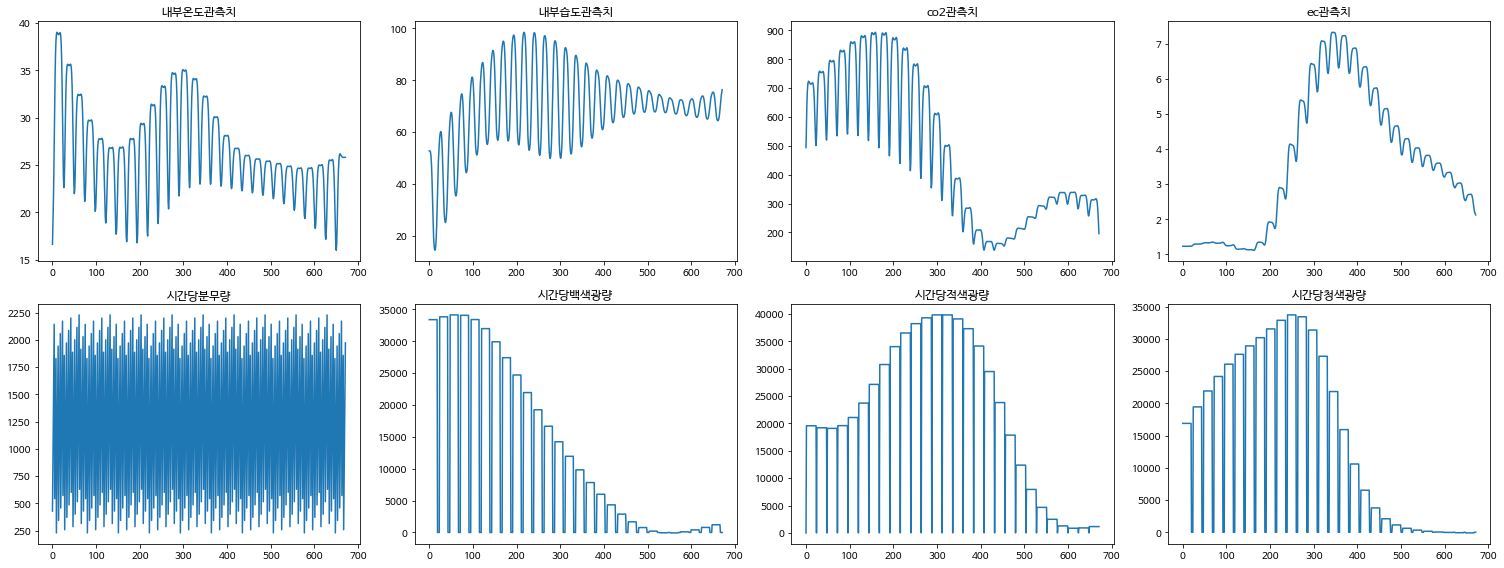

In [110]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(21,8))
for i, col in enumerate(UNIQUE_FEARURES):
    df = best_x[col].to_frame().reset_index(drop=True)
    axs[i//4][i%4].plot(df[col])
    axs[i//4][i%4].set_title(f"{col}")
plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}best_x.jpg', format='jpg')
# plt.show()

### 환경변수 변화요인에 의한 Target값의 변화
* Optuna의 각 Epoch에서 X축은 각 인수의 값이고, Y축은 추론된 Target값에 대해 (값 - 최저값) / (최대값 - 최저값)으로 구한 값을 표시한 것으로, 인수의 값에 따른 Target값의 변화를 볼 수 있음

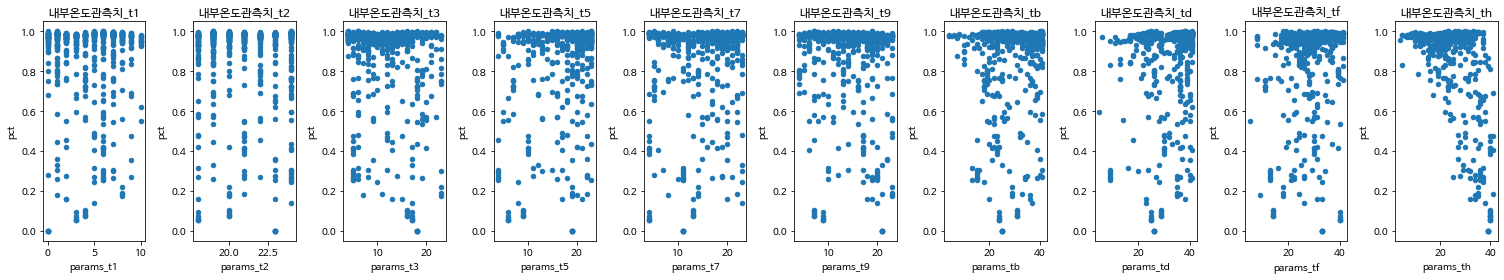

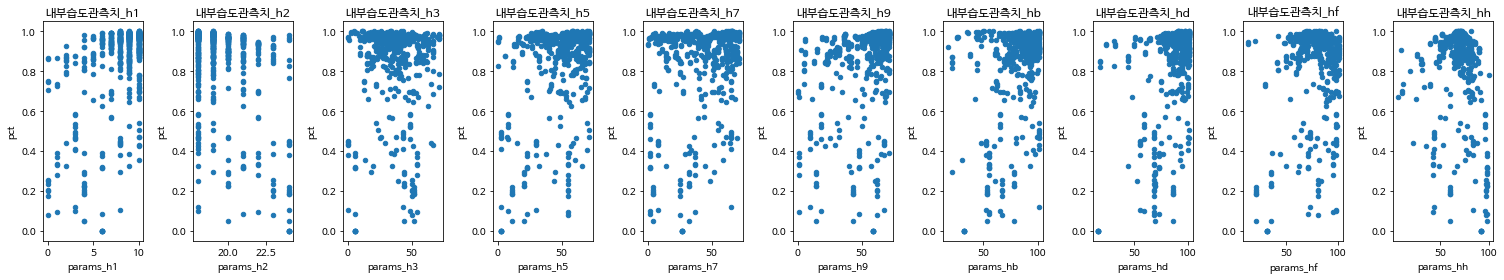

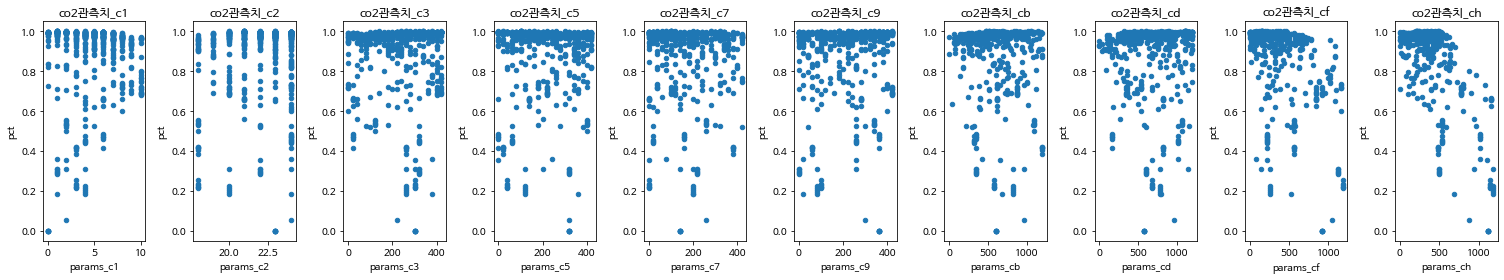

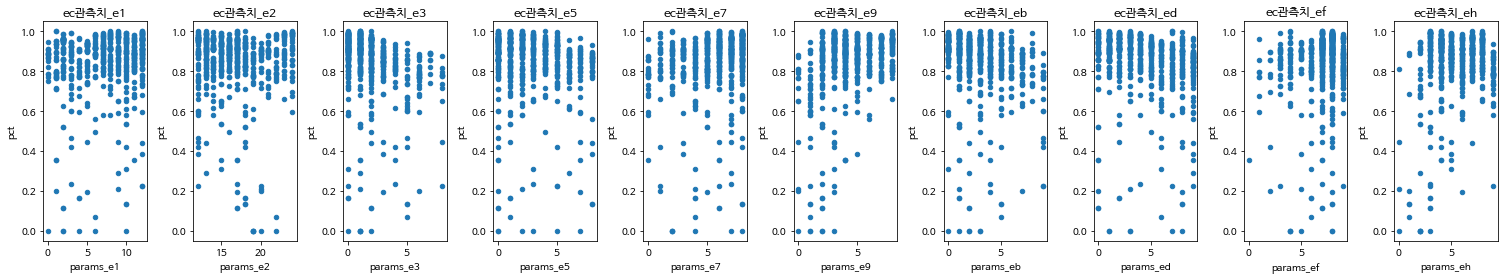

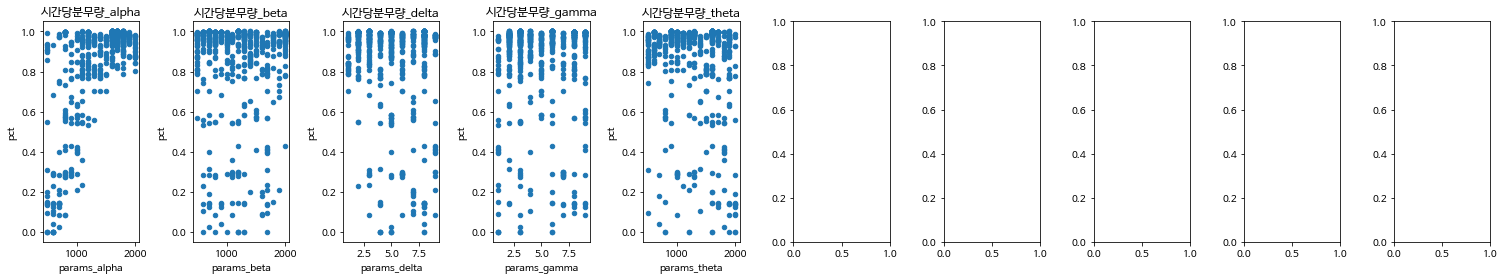

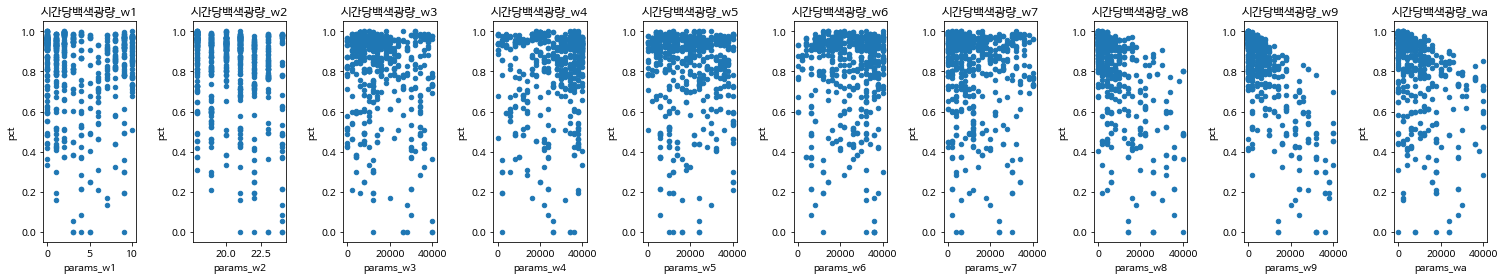

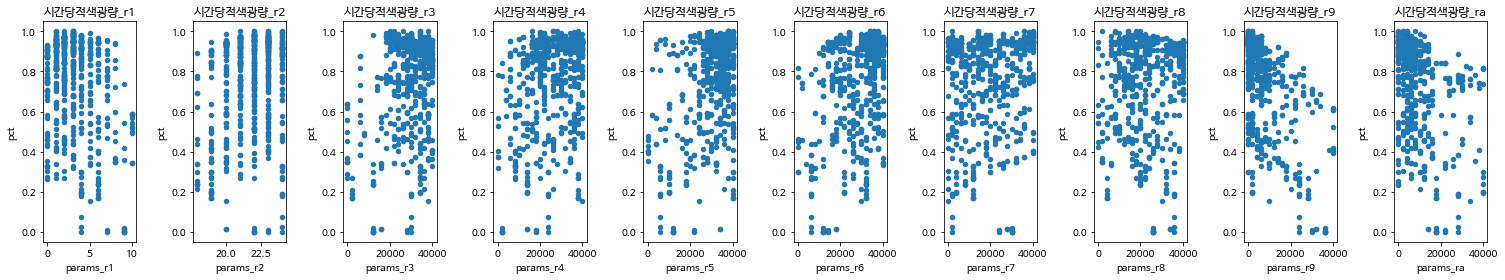

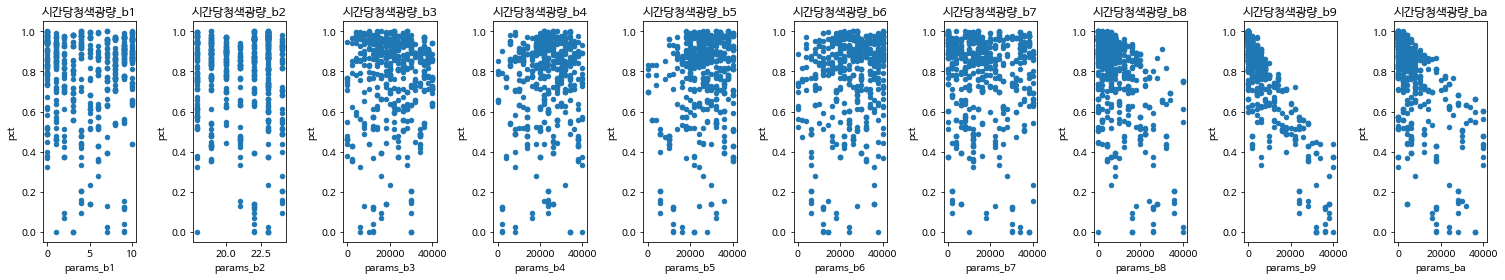

In [111]:
for col in UNIQUE_FEARURES:
    df = read_study_trials(col)
    fig, axs = plt.subplots(nrows=1, ncols=10, figsize=(21,4))
    cols = df.filter(like='params').columns
    if (len(cols)>10):
        cols = [cols[i] for i in [0,1]+list(range(2,len(cols),2))]
    for i, param in enumerate(cols):
        ax = axs[i]
        df.plot.scatter(x=param, y='pct', ax=ax)
        ax.set_title(f"{col}_{param.split('_')[1]}")
    plt.tight_layout()
    plt.savefig(f'{RESULTS_DIR}{col}.jpg', format='jpg')
    # plt.show()

In [112]:
test_x = dataset.make_test_raw(best_x)

_test_x, test_y = dataset.make_test(test_x.copy())
preds = automl.predict(_test_x)
preds = dataset.inverse_transform(preds).flatten()

test_y['preds'] = preds.flatten()
test_y[TARGET] = power_fit(preds.flatten())

test_x.to_csv(f'{RESULTS_DIR}TEST_99_X.csv', index=False)
test_y[['DAT',TARGET]].to_csv(f'{RESULTS_DIR}TEST_99_y.csv', index=False)
print(f'Train Min: {min_y[TARGET].iloc[-1]:.3f}, Train Max: {max_y[TARGET].iloc[-1]:.3f}, Optuna: {test_y["preds"].iloc[-1]:.3f}, curve_fit(): {test_y[TARGET].iloc[-1]:.3f}')
print(f'Saved {RESULTS_DIR}TEST_99_X & y.csv')

Train Min: 22.931, Train Max: 164.150, Optuna: 171.469, curve_fit(): 196.329
Saved results/TEST_99_X & y.csv


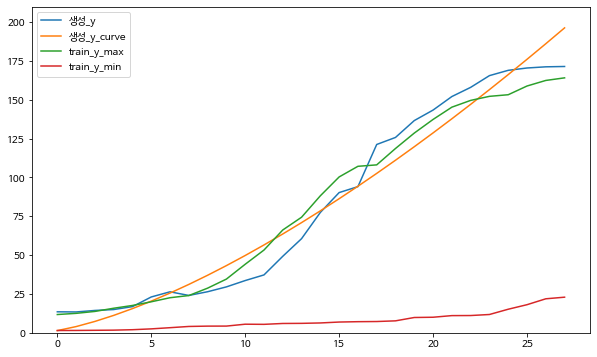

In [113]:
plt.figure(figsize=(10,6))
plt.plot(test_y['preds'], label='생성_y')
plt.plot(test_y[TARGET] , label='생성_y_curve')
plt.plot(max_y[TARGET]  , label='train_y_max')
plt.plot(min_y[TARGET]  , label='train_y_min')
# plt.plot(np.linspace(0,1,28)**2 * 280, label='target')

plt.ylim(0,210)
plt.legend()
plt.savefig(f'{RESULTS_DIR}best_y.jpg', format='jpg')